# Library Install

model library install
```bash
pip install git+https://github.com/abcd-EGH/srnn-ae.git
```

In [1]:
!git clone https://github.com/numenta/NAB.git

Cloning into 'NAB'...
remote: Enumerating objects: 7119, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 7119 (delta 73), reused 62 (delta 25), pack-reused 6915 (from 1)
Receiving objects: 100% (7119/7119), 86.82 MiB | 31.29 MiB/s, done.
Resolving deltas: 100% (4947/4947), done.
Updating files: 100% (1186/1186), done.


In [2]:
!pip install git+https://github.com/abcd-EGH/srnn-ae.git -q
!pip install arch -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 12.5 MB/s eta 0:00:00


In [3]:
from srnn_ae import EASLAE, TimeSeriesDataset, set_random_seed, hyperparameter_setting, read_dataset, train,\
                    data_plot_with_anomalies, compute_reconstruction_errors, evaluate_and_visualize
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

In [4]:
# 가설 이름 설정
h_name = 'H6_Attention'

# machine_temperature_system_failure

## Train

Hyperparameter & Hypothesis Number Setting Complete.
Model Initialization Complete.
Processing file: realKnownCause/machine_temperature_system_failure.csv
Data Load Complete.
Loss function & Optimizer Complete.
[Args]
{'N': 10, 'input_size': 1, 'hidden_size': 8, 'output_size': 1, 'num_layers': 1, 'limit_skip_steps': 10, 'learning_rate': 0.001, 'l1_lambda': 1e-05, 'batch_size': 22660, 'window_size': 36, 'num_epochs': 1000, 'random_seed': 777}

[Model]
EASLAE(
  (autoencoders): ModuleList(
    (0-9): 10 x AutoEncoder(
      (encoder): Encoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
      )
      (decoder): Decoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
        (output_layer): Linear(in_features=16, out_features=1, bias=True)
        (attention): Linear(in_features=16, out_features=8, bias=True)
        (softmax): Softmax(dim=1)
      )
    )
 

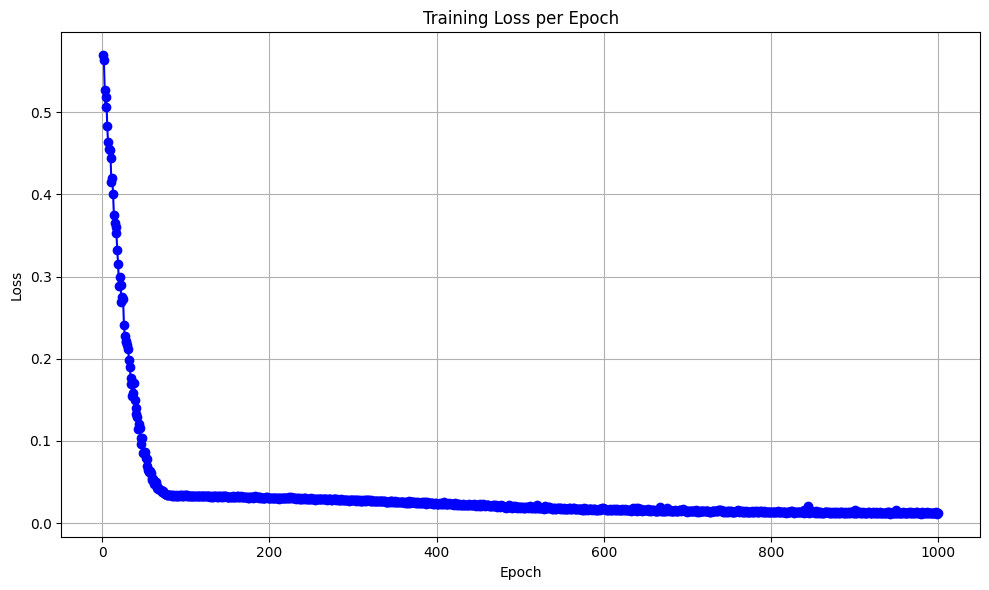

모델 가중치가 results/H6_Attention/machine_temperature_system_failure/ensemble_autoencoder_weights.pth'에 저장되었습니다.


In [4]:
set_random_seed()

# 하이퍼파라미터 및 가설 넘버 설정
args = hyperparameter_setting(N=10, hidden_size=8, num_layers=1, num_epochs=1000,
                              window_size=36, l1_lambda=1e-5, limit_skip_steps=10, learning_rate=1e-3)
file_name = './NAB/data/realKnownCause/machine_temperature_system_failure.csv'
h=os.path.join(h_name, os.path.basename(file_name).split('.')[0]) # 꼭 확인하기!
print("Hyperparameter & Hypothesis Number Setting Complete.")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)
model = EASLAE(
    N=args['N'],
    input_size=args['input_size'],
    hidden_size=args['hidden_size'],
    output_size=args['output_size'],
    num_layers=args['num_layers'],
    limit_skip_steps=args['limit_skip_steps'],
    seed=args['random_seed'],
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("Model Initialization Complete.")

# Prepare data and create Dataset
abnormal_data, abnormal_label = read_dataset(file_name)
abnormal_data, abnormal_label = abnormal_data[:], abnormal_label[:]  # Remove last data point to fit window and batch size

window_size = args['window_size']
stride = 1

# Create the train dataset
train_dataset = TimeSeriesDataset(abnormal_data, abnormal_label, window_size, stride=stride)
batch_size = args['batch_size'] = len(train_dataset) # args['batch_size']

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print("Data Load Complete.")

# 손실 함수 및 옵티마이저 설정 - 논문에선 Adadelta를 사용했으나, 20 epoch 동안 loss가 떨어지지 않아 Adam으로 대체
criterion = nn.MSELoss() # MSELoss, L1Loss, SmoothL1Loss
optimizer = optim.AdamW(model.parameters(), lr=args['learning_rate'], weight_decay=1e-5)
print("Loss function & Optimizer Complete.")

print("[Args]")
print(args)
print()

print("[Model]")
print(model)
print()

print("[Data]")
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of batches in train dataloader: {len(train_dataloader)}")
print()

print("[Criterion & Optimizer]")
print(criterion)
print(optimizer)
print()

# 학습 실행
print('현재 가설명:', h)
print()

train(
    model=model,
    dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    l1_lambda=args['l1_lambda'],
    num_epochs=args['num_epochs'],
    h=h
)

# 모델 가중치 저장
torch.save(model.state_dict(), f'results/{h}/ensemble_autoencoder_weights.pth')
print(f"모델 가중치가 results/{h}/ensemble_autoencoder_weights.pth'에 저장되었습니다.")

## Test

In [7]:
model.load_state_dict(torch.load(f'results/{h}/ensemble_autoencoder_weights.pth', weights_only=True))
print("모델 가중치가 로드되었습니다.")

# 테스트 파일 불러오기
test_file_name = file_name # Train한 file과 동일한 file로 진행
test_abnormal_data, test_abnormal_label = read_dataset(test_file_name)
test_abnormal_data, test_abnormal_label = test_abnormal_data[:], test_abnormal_label[:]

# 모든 데이터를 테스트에 사용
test_dataset = TimeSeriesDataset(test_abnormal_data, test_abnormal_label, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

total_length = len(test_abnormal_data)

all_errors, reconstructed_data, binary_labels = compute_reconstruction_errors(model, test_dataloader, device, total_length, test_abnormal_label)

모델 가중치가 로드되었습니다.
Processing file: realKnownCause/machine_temperature_system_failure.csv
Testing Complete.


Using static Reconstruction Error Threshold (95th percentile): 0.006482
[Classification Metrics]
Precision: 0.5040
Recall: 0.2522
F1-Score: 0.3362
ROC AUC: 0.7528
PR AUC: 0.3923
Cohen Kappa: 0.2888

Reconstruction error plot saved to results\H6_Attention\machine_temperature_system_failure/StaticThreshold\reconstruction_error_static_threshold.png


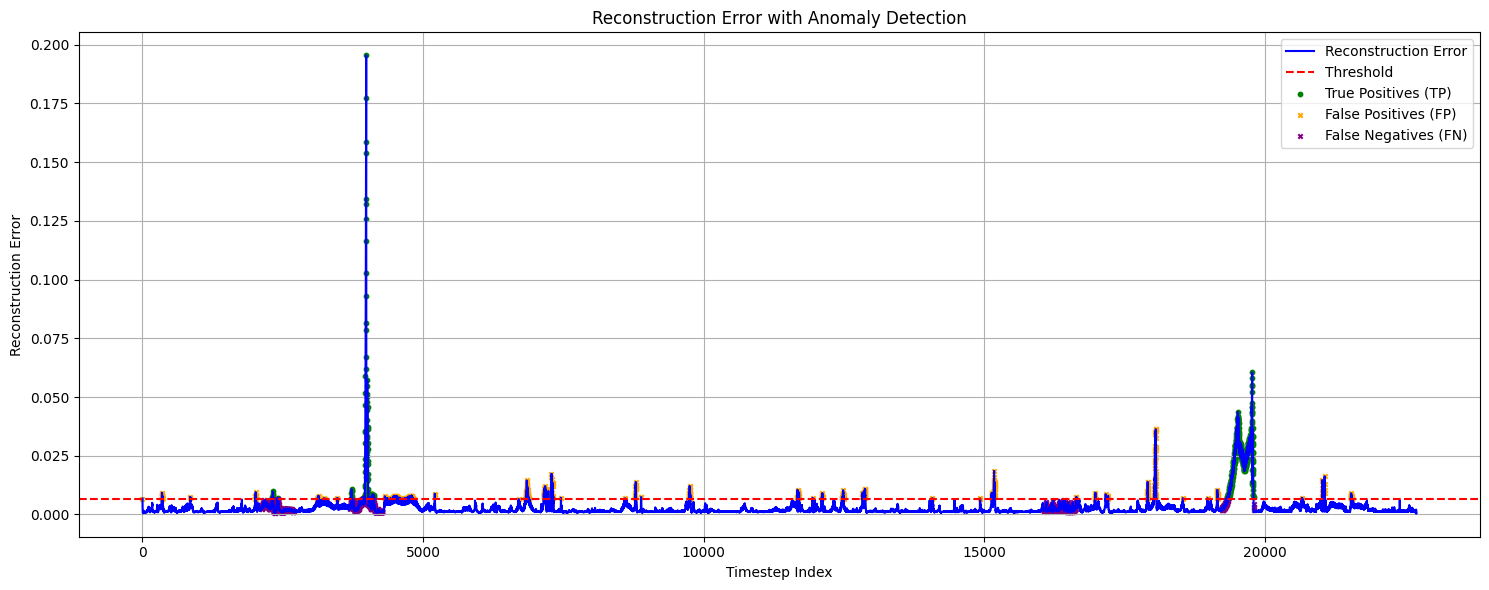

Actual vs Reconstructed Data plot saved to results\H6_Attention\machine_temperature_system_failure/StaticThreshold\actual_vs_reconstructed_data.png


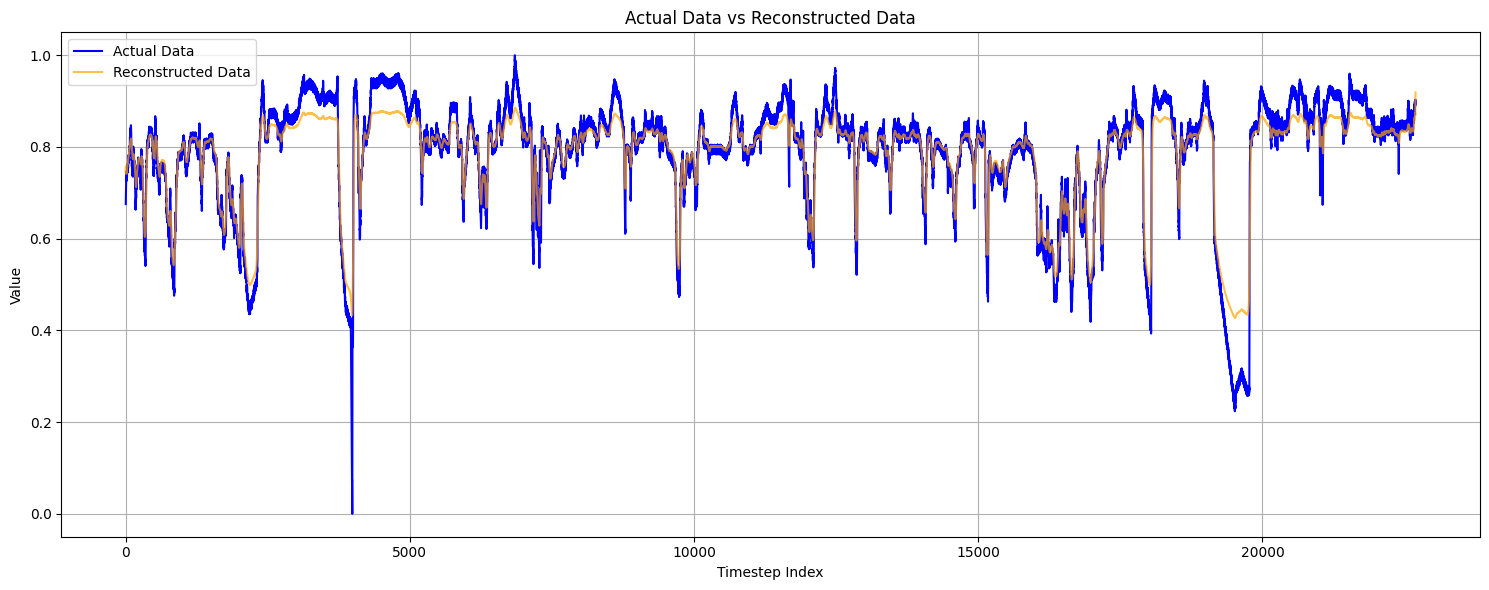

ROC curve plot saved to results\H6_Attention\machine_temperature_system_failure/StaticThreshold\roc_curve_all_data.png


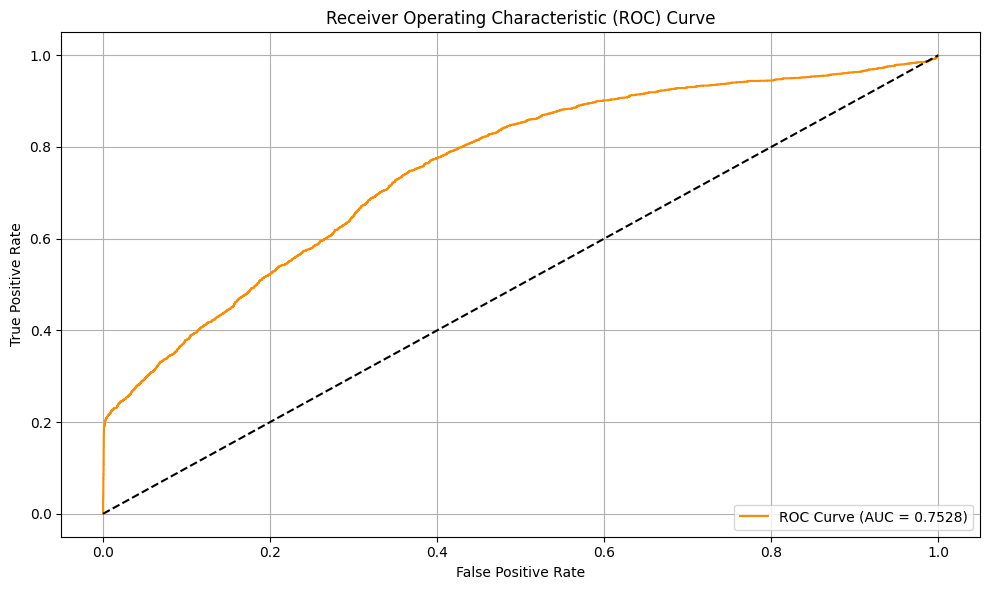

PR curve plot saved to results\H6_Attention\machine_temperature_system_failure/StaticThreshold\pr_curve_all_data.png


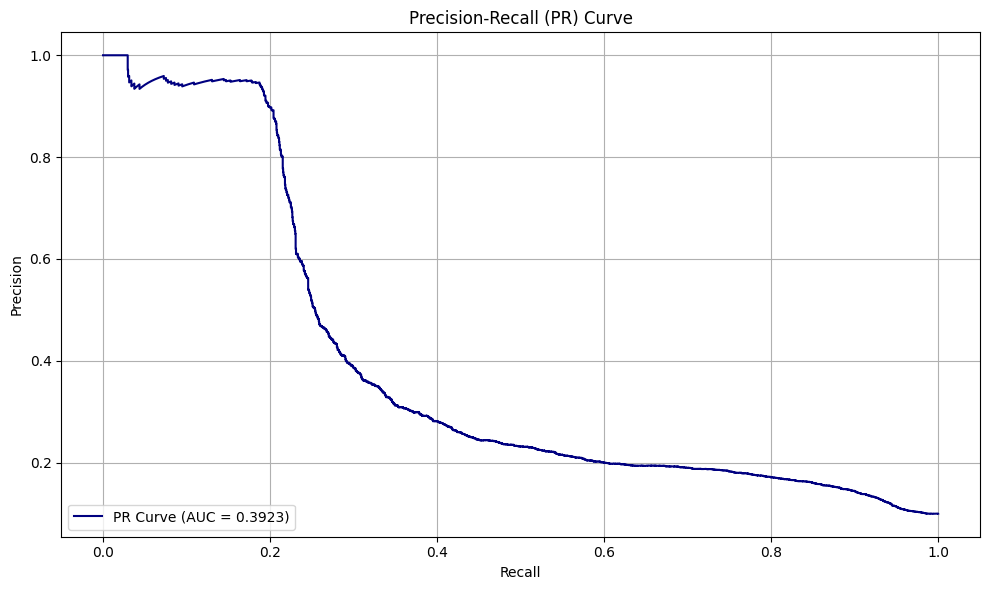

Confusion matrix plot saved to results\H6_Attention\machine_temperature_system_failure/StaticThreshold\confusion_matrix.png


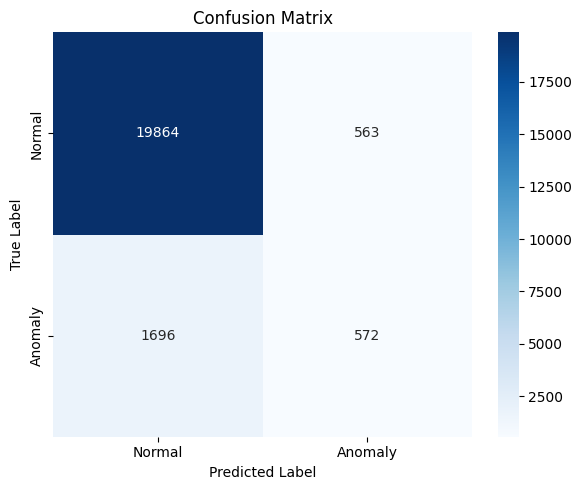

Reconstruction error with anomalies plot saved to results\H6_Attention\machine_temperature_system_failure/StaticThreshold\reconstruction_error_with_anomalies_static.png


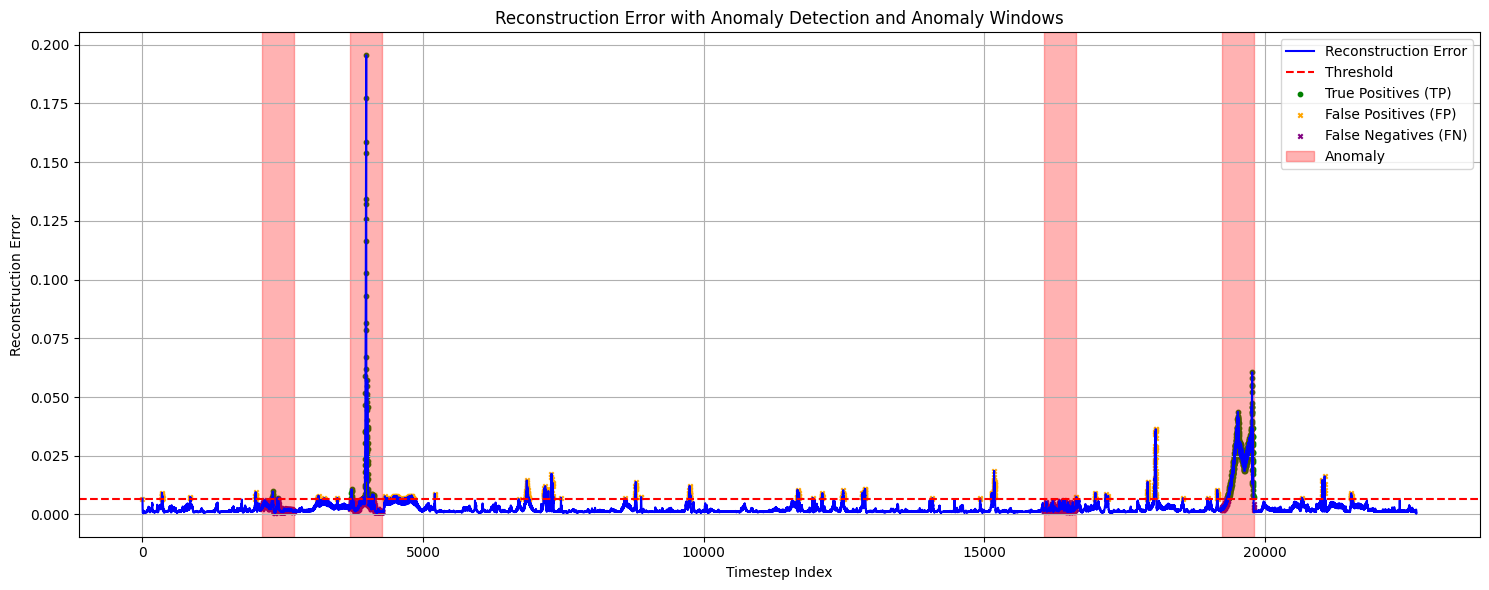

In [14]:
# 테스트 실행 (Static Threshold)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/StaticThreshold',
    threshold_method='static',
    threshold_percentile=95,
)

Using dynamic Reconstruction Error Threshold based on 20-window moving average and 1.0*std
[Classification Metrics]
Precision: 0.1135
Recall: 0.2703
F1-Score: 0.1599
ROC AUC: 0.6288
PR AUC: 0.3385
Cohen Kappa: 0.0223

Reconstruction error plot saved to results/H6_Attention/machine_temperature_system_failure/DynamicThresholdwithMA/reconstruction_error_moving_avg_threshold.png


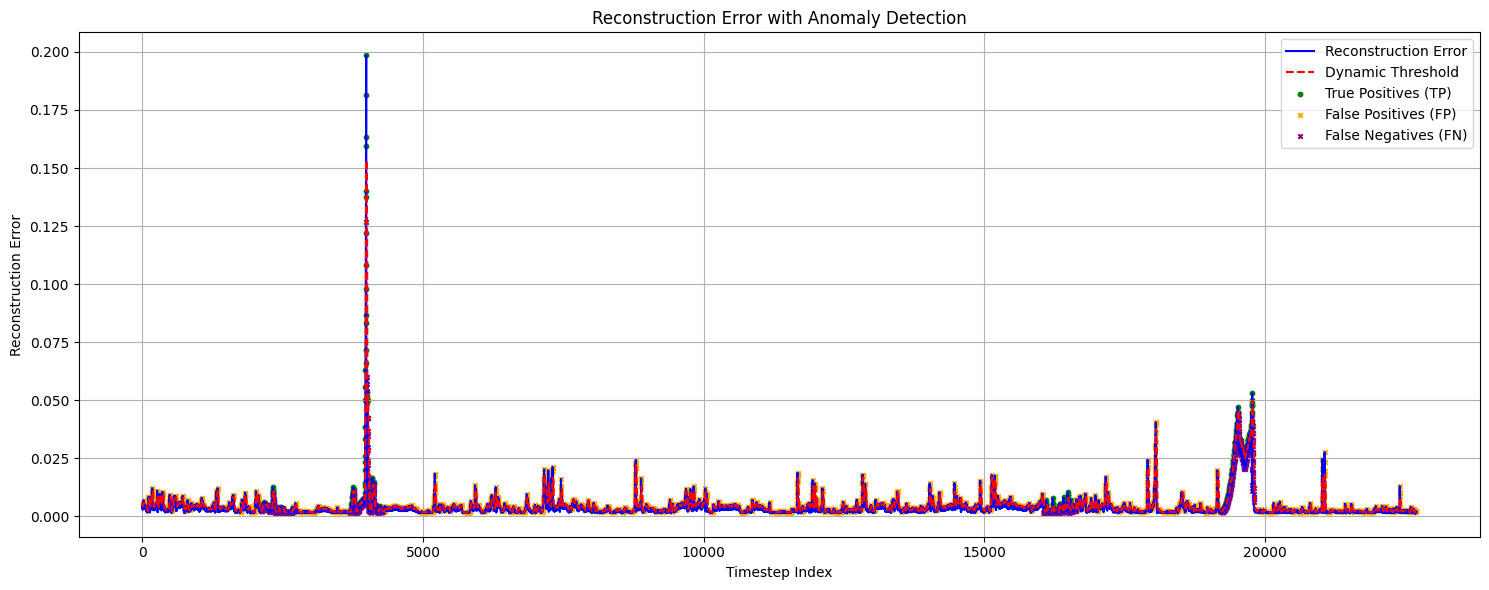

Actual vs Reconstructed Data plot saved to results/H6_Attention/machine_temperature_system_failure/DynamicThresholdwithMA/actual_vs_reconstructed_data.png


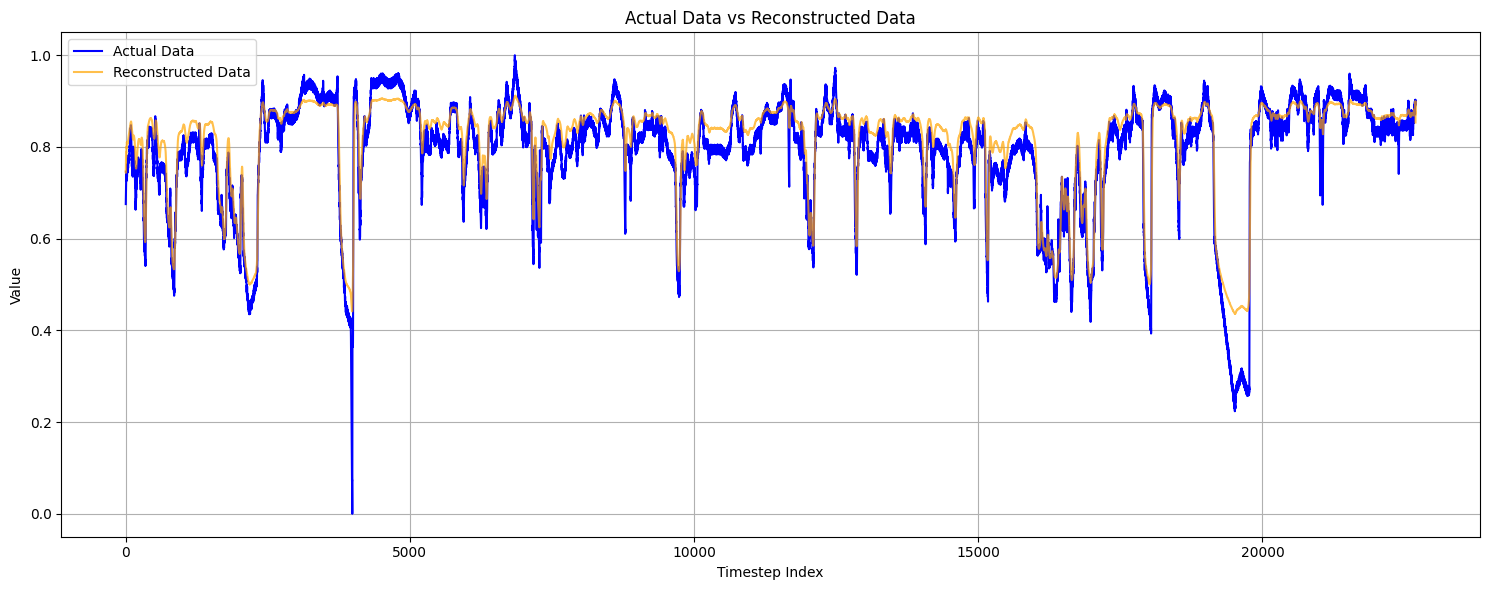

ROC curve plot saved to results/H6_Attention/machine_temperature_system_failure/DynamicThresholdwithMA/roc_curve_all_data.png


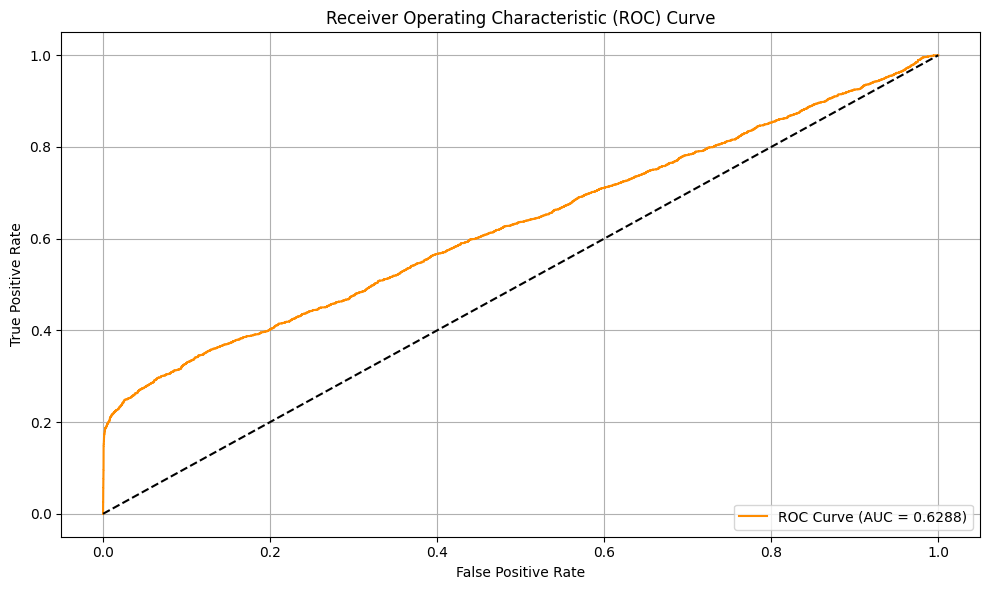

PR curve plot saved to results/H6_Attention/machine_temperature_system_failure/DynamicThresholdwithMA/pr_curve_all_data.png


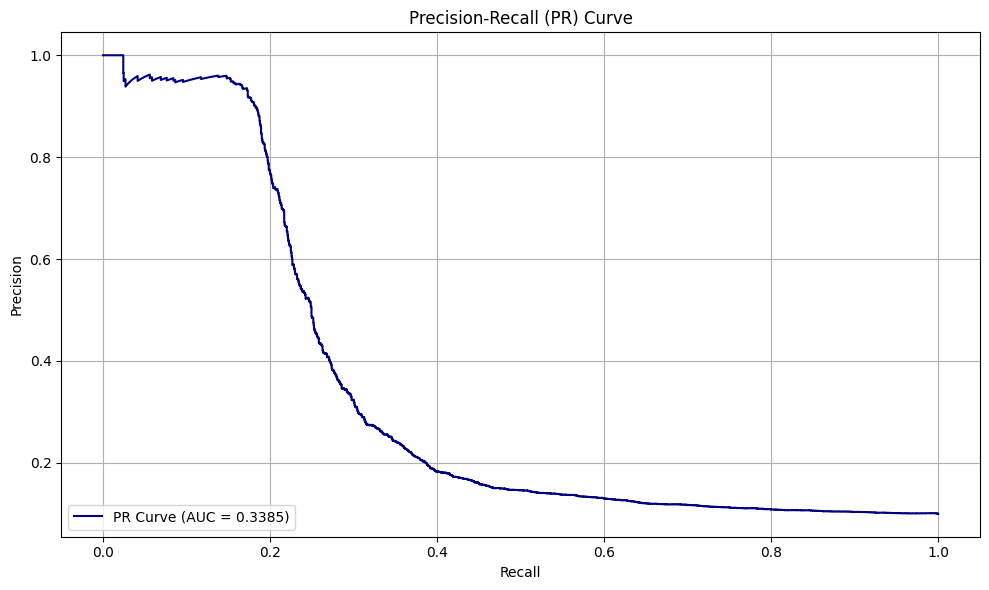

Confusion matrix plot saved to results/H6_Attention/machine_temperature_system_failure/DynamicThresholdwithMA/confusion_matrix.png


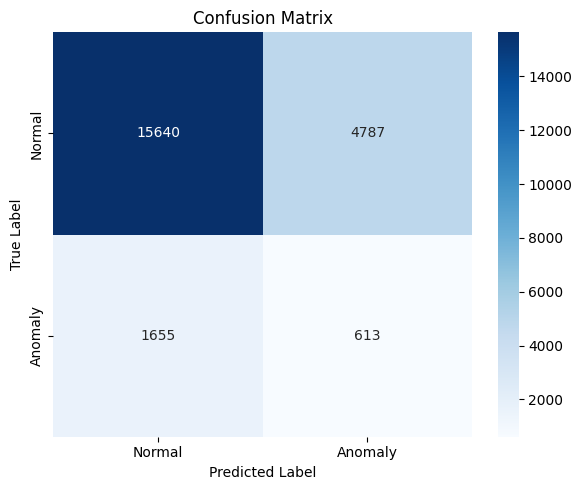

Reconstruction error with anomalies plot saved to results/H6_Attention/machine_temperature_system_failure/DynamicThresholdwithMA/reconstruction_error_with_anomalies_moving_avg.png


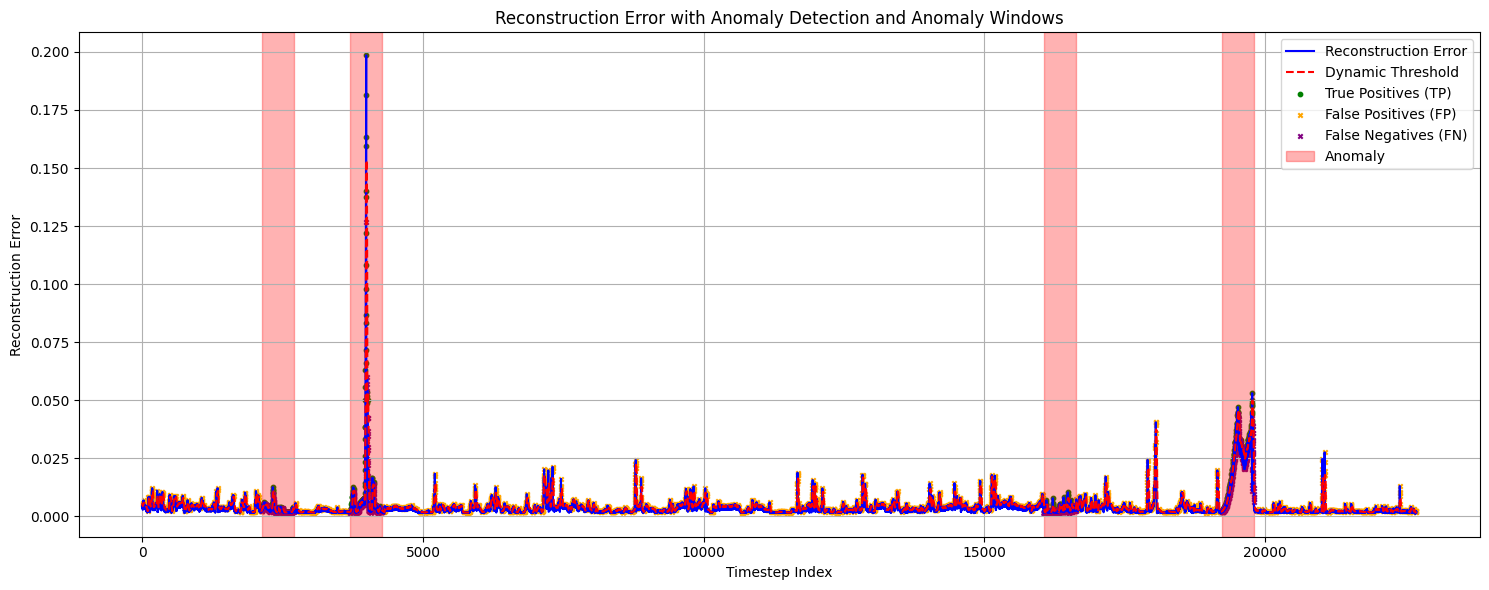

In [7]:
# 테스트 실행 (Dynamic Threshold, Moving Average)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithMA',
    threshold_method='moving_avg',
    k=1.0
)

Fitting GARCH(1,1) model on scaled reconstruction errors...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                216161.
Distribution:                  Normal   AIC:                          -432316.
Method:            Maximum Likelihood   BIC:                          -432292.
                                        No. Observations:                22695
Date:                Wed, Dec 04 2024   Df Residuals:                    22695
Time:                        02:44:11   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

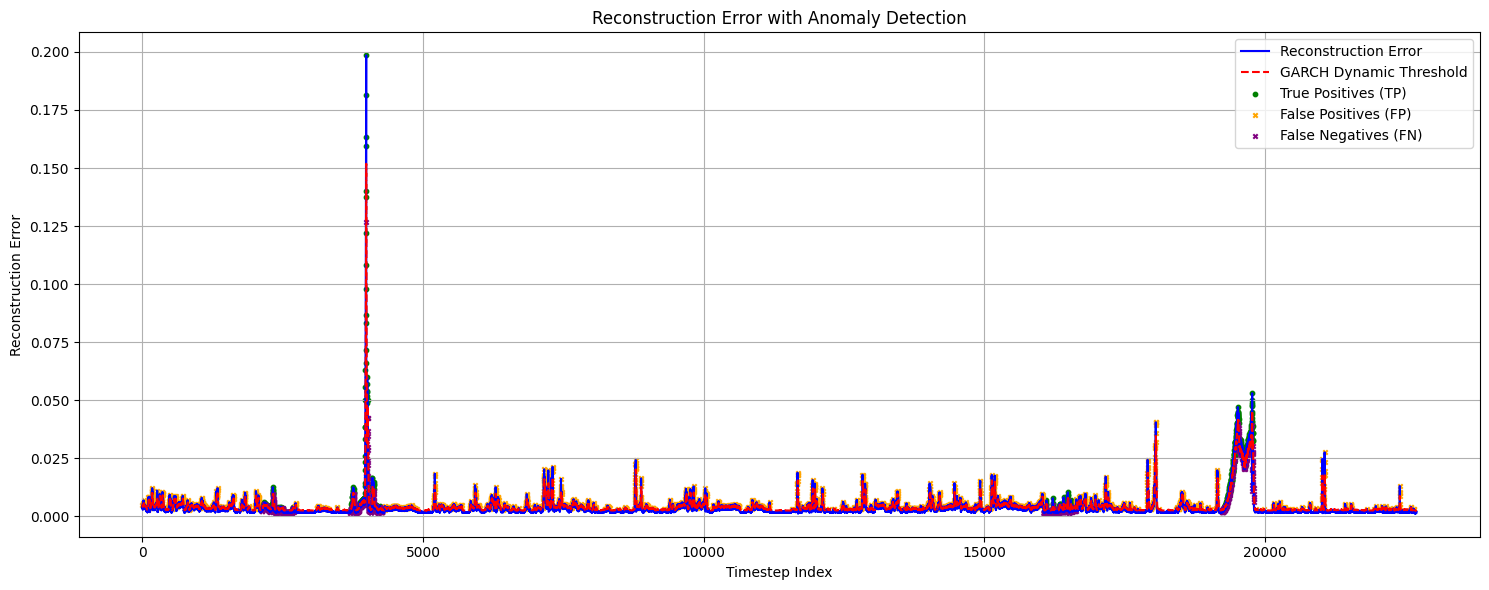

Actual vs Reconstructed Data plot saved to results/H6_Attention/machine_temperature_system_failure/DynamicThresholdwithGARCH/actual_vs_reconstructed_data.png


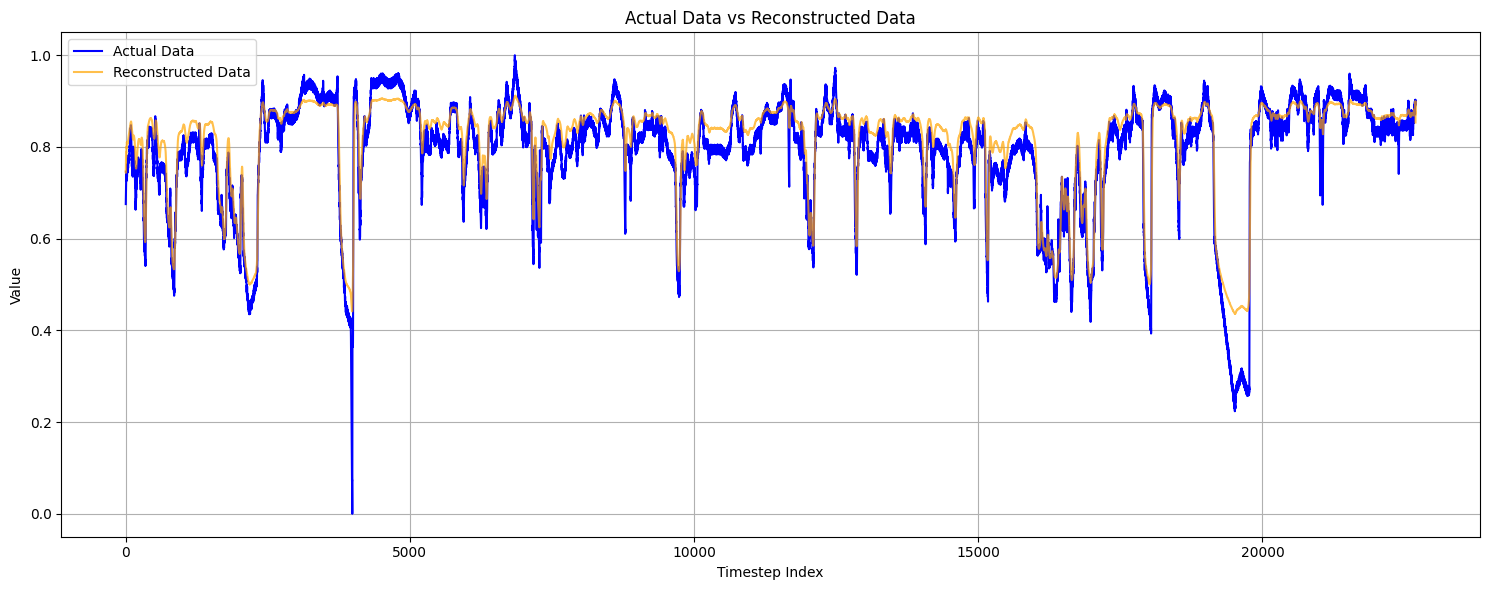

ROC curve plot saved to results/H6_Attention/machine_temperature_system_failure/DynamicThresholdwithGARCH/roc_curve_all_data.png


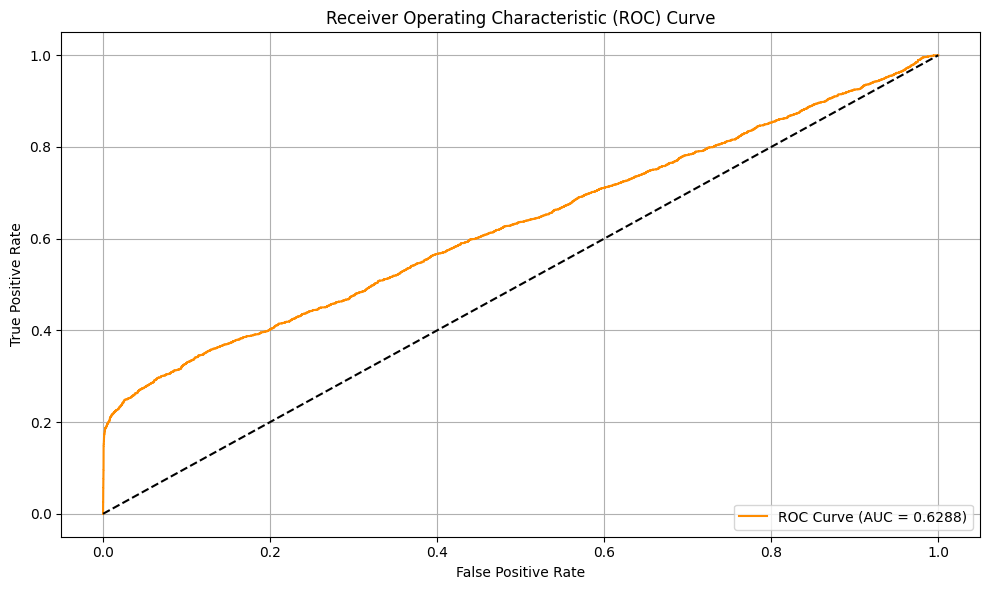

PR curve plot saved to results/H6_Attention/machine_temperature_system_failure/DynamicThresholdwithGARCH/pr_curve_all_data.png


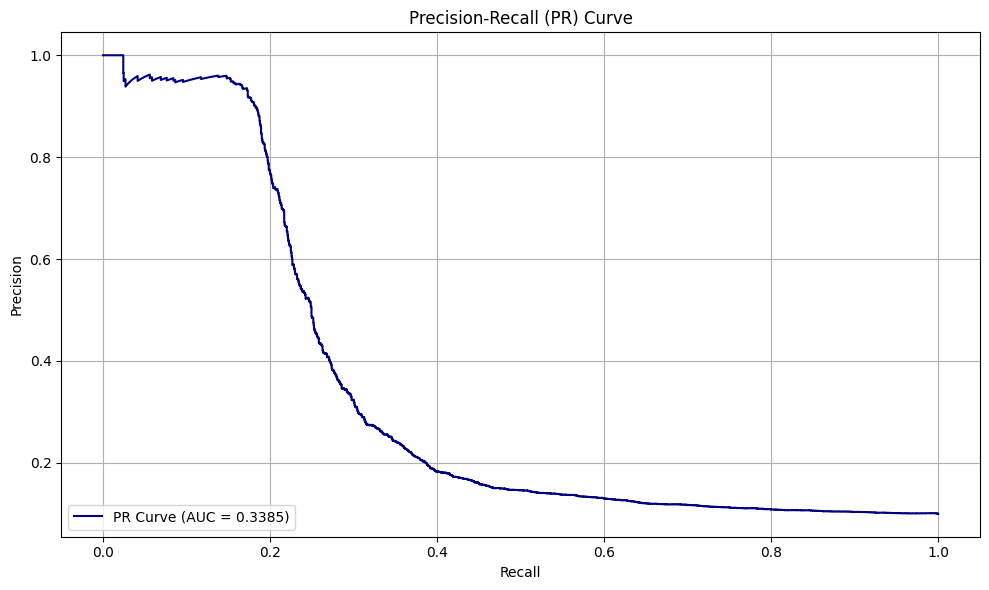

Confusion matrix plot saved to results/H6_Attention/machine_temperature_system_failure/DynamicThresholdwithGARCH/confusion_matrix.png


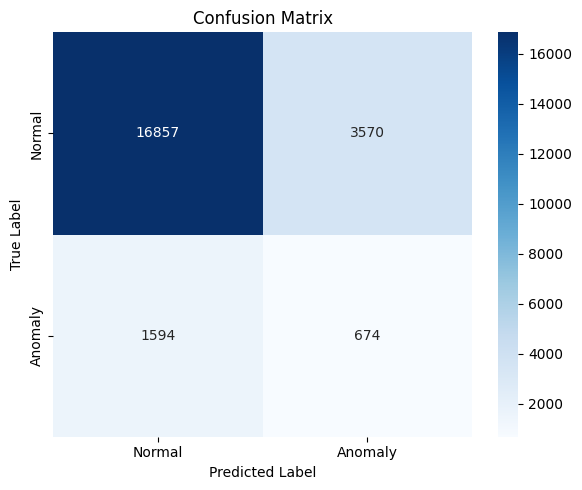

Reconstruction error with anomalies plot saved to results/H6_Attention/machine_temperature_system_failure/DynamicThresholdwithGARCH/reconstruction_error_with_anomalies_garch.png


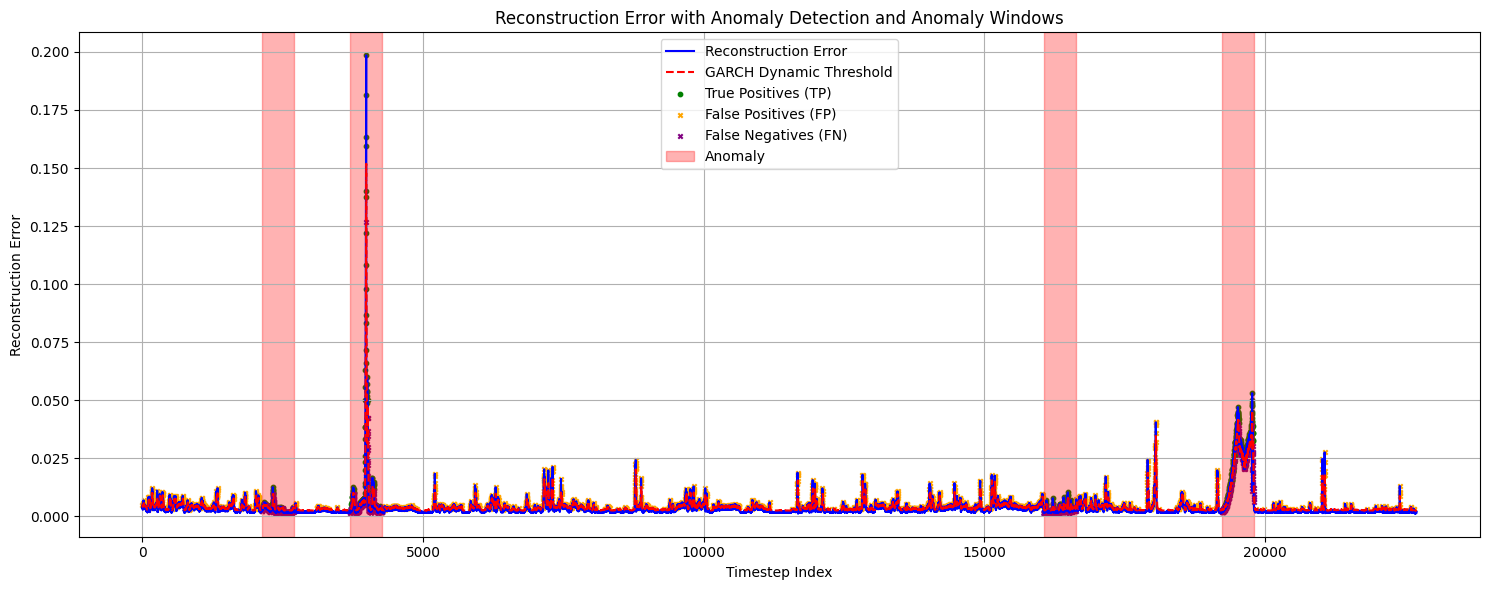

In [8]:
# 테스트 실행 (Dynamic Threshold, GARCH)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithGARCH',
    threshold_method='garch',
    k=1.0,
)

# ec2_cpu_utilization_825cc2

## Train

Hyperparameter & Hypothesis Number Setting Complete.
Model Initialization Complete.
Processing file: realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv
Data Load Complete.
Loss function & Optimizer Complete.
[Args]
{'N': 10, 'input_size': 1, 'hidden_size': 8, 'output_size': 1, 'num_layers': 1, 'limit_skip_steps': 10, 'learning_rate': 0.001, 'l1_lambda': 1e-05, 'batch_size': 3997, 'window_size': 36, 'num_epochs': 1000, 'random_seed': 777}

[Model]
EASLAE(
  (autoencoders): ModuleList(
    (0-9): 10 x AutoEncoder(
      (encoder): Encoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
      )
      (decoder): Decoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
        (output_layer): Linear(in_features=16, out_features=1, bias=True)
        (attention): Linear(in_features=16, out_features=8, bias=True)
        (softmax): Softmax(dim=1)
      )
    )
  )
)



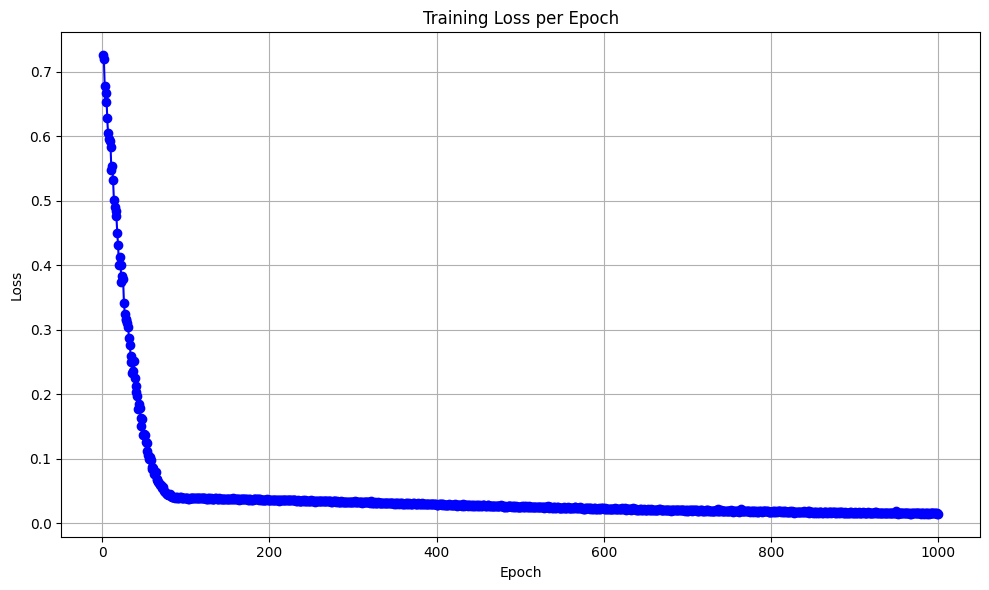

모델 가중치가 results/H6_Attention/ec2_cpu_utilization_825cc2/ensemble_autoencoder_weights.pth'에 저장되었습니다.


In [9]:
set_random_seed()

# 하이퍼파라미터 및 가설 넘버 설정
args = hyperparameter_setting(N=10, hidden_size=8, num_layers=1, num_epochs=1000,
                              window_size=36, l1_lambda=1e-5, limit_skip_steps=10, learning_rate=1e-3)
file_name = './NAB/data/realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv'
h=os.path.join(h_name, os.path.basename(file_name).split('.')[0]) # 꼭 확인하기!
print("Hyperparameter & Hypothesis Number Setting Complete.")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)
model = EASLAE(
    N=args['N'],
    input_size=args['input_size'],
    hidden_size=args['hidden_size'],
    output_size=args['output_size'],
    num_layers=args['num_layers'],
    limit_skip_steps=args['limit_skip_steps'],
    seed=args['random_seed'],
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("Model Initialization Complete.")

# Prepare data and create Dataset
abnormal_data, abnormal_label = read_dataset(file_name)
abnormal_data, abnormal_label = abnormal_data[:], abnormal_label[:]  # Remove last data point to fit window and batch size

window_size = args['window_size']
stride = 1

# Create the train dataset
train_dataset = TimeSeriesDataset(abnormal_data, abnormal_label, window_size, stride=stride)
batch_size = args['batch_size'] = len(train_dataset) # args['batch_size']

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print("Data Load Complete.")

# 손실 함수 및 옵티마이저 설정 - 논문에선 Adadelta를 사용했으나, 20 epoch 동안 loss가 떨어지지 않아 Adam으로 대체
criterion = nn.MSELoss() # MSELoss, L1Loss, SmoothL1Loss
optimizer = optim.AdamW(model.parameters(), lr=args['learning_rate'], weight_decay=1e-5)
print("Loss function & Optimizer Complete.")

print("[Args]")
print(args)
print()

print("[Model]")
print(model)
print()

print("[Data]")
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of batches in train dataloader: {len(train_dataloader)}")
print()

print("[Criterion & Optimizer]")
print(criterion)
print(optimizer)
print()

# 학습 실행
print('현재 가설명:', h)
print()

train(
    model=model,
    dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    l1_lambda=args['l1_lambda'],
    num_epochs=args['num_epochs'],
    h=h
)

# 모델 가중치 저장
torch.save(model.state_dict(), f'results/{h}/ensemble_autoencoder_weights.pth')
print(f"모델 가중치가 results/{h}/ensemble_autoencoder_weights.pth'에 저장되었습니다.")

## Test

In [26]:
model.load_state_dict(torch.load(f'results/{h}/ensemble_autoencoder_weights.pth', weights_only=True))
print("모델 가중치가 로드되었습니다.")

# 테스트 파일 불러오기
test_file_name = file_name # Train한 file과 동일한 file로 진행
test_abnormal_data, test_abnormal_label = read_dataset(test_file_name)
test_abnormal_data, test_abnormal_label = test_abnormal_data[:], test_abnormal_label[:]

# 모든 데이터를 테스트에 사용
test_dataset = TimeSeriesDataset(test_abnormal_data, test_abnormal_label, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

total_length = len(test_abnormal_data)

all_errors, reconstructed_data, binary_labels = compute_reconstruction_errors(model, test_dataloader, device, total_length, test_abnormal_label)

모델 가중치가 로드되었습니다.
Processing file: realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv
Testing Complete.


Using static Reconstruction Error Threshold (95th percentile): 0.007484
[Classification Metrics]
Precision: 0.6238
Recall: 0.3673
F1-Score: 0.4624
ROC AUC: 0.6864
PR AUC: 0.3296
Cohen Kappa: 0.4262

Reconstruction error plot saved to results\H6_Attention\ec2_cpu_utilization_825cc2/StaticThreshold\reconstruction_error_static_threshold.png


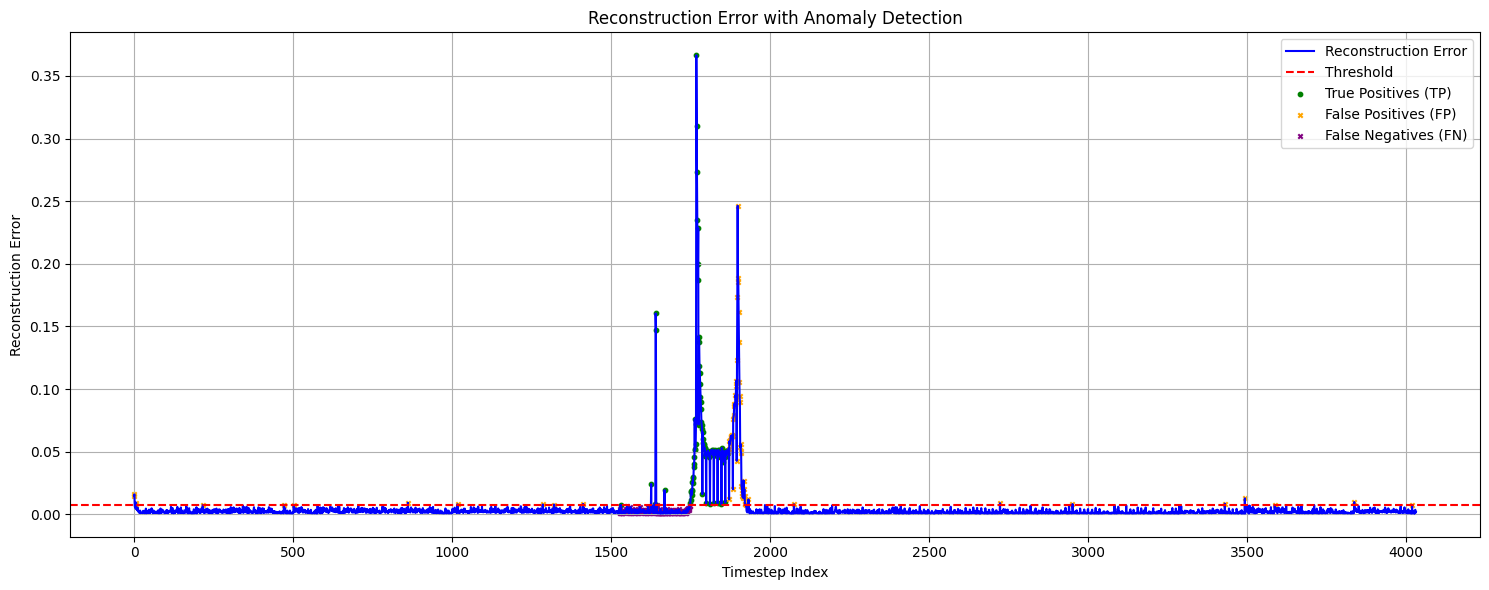

Actual vs Reconstructed Data plot saved to results\H6_Attention\ec2_cpu_utilization_825cc2/StaticThreshold\actual_vs_reconstructed_data.png


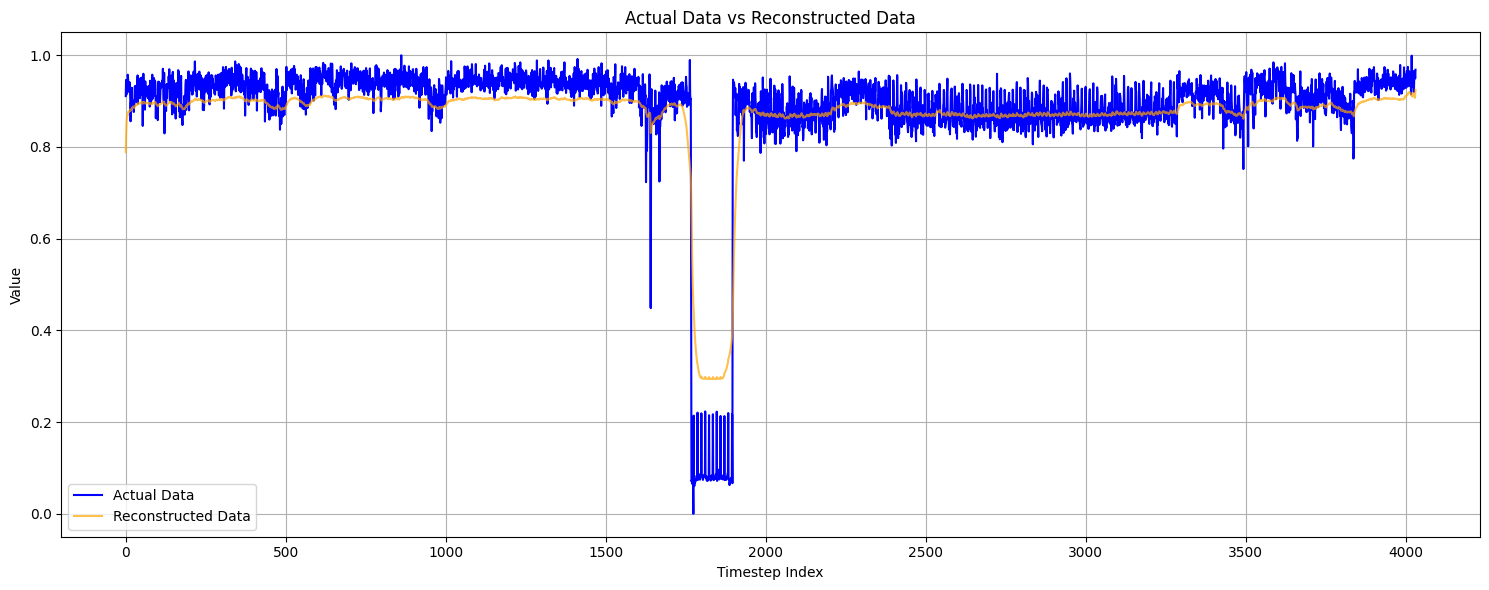

ROC curve plot saved to results\H6_Attention\ec2_cpu_utilization_825cc2/StaticThreshold\roc_curve_all_data.png


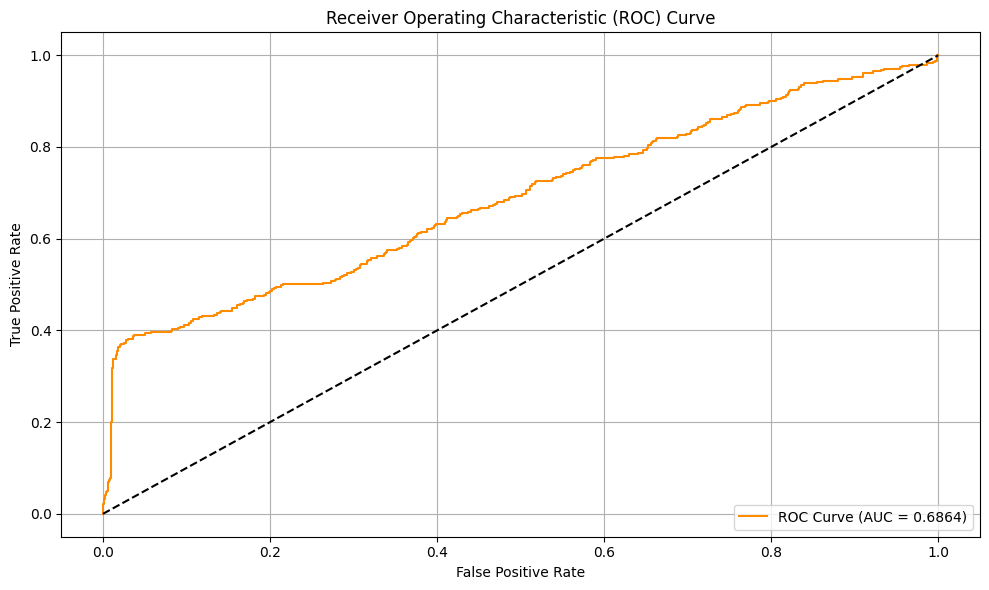

PR curve plot saved to results\H6_Attention\ec2_cpu_utilization_825cc2/StaticThreshold\pr_curve_all_data.png


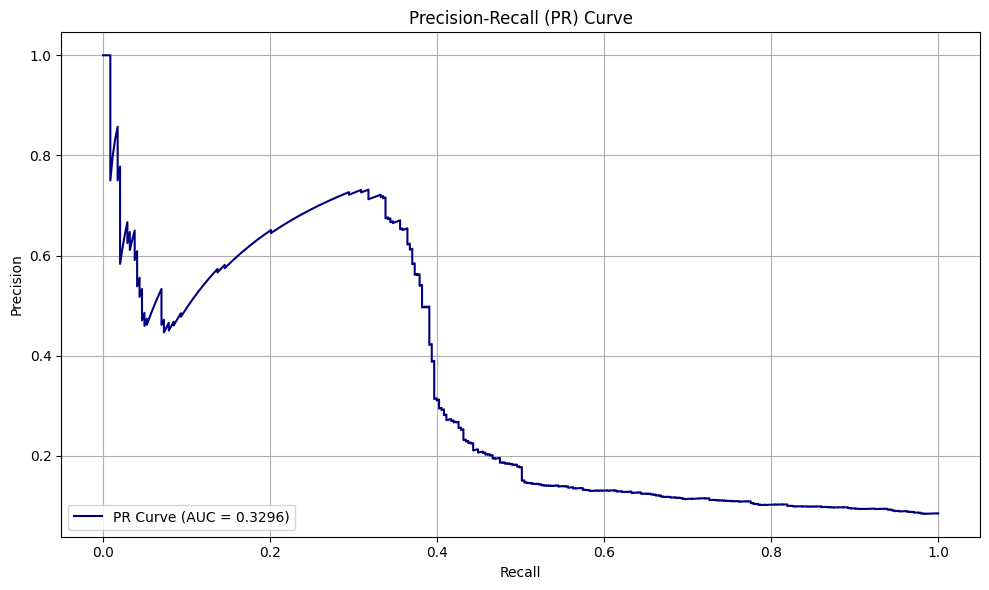

Confusion matrix plot saved to results\H6_Attention\ec2_cpu_utilization_825cc2/StaticThreshold\confusion_matrix.png


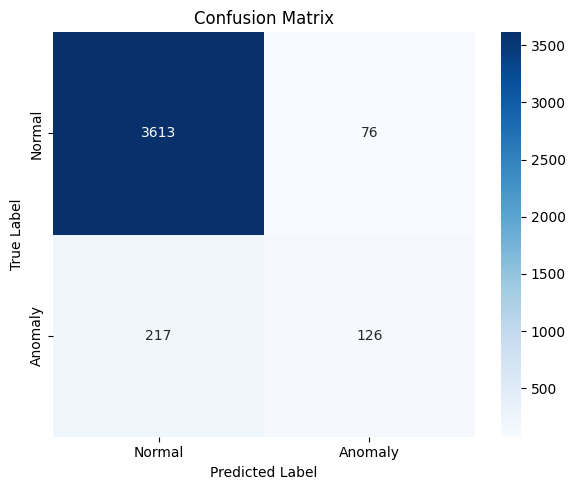

Reconstruction error with anomalies plot saved to results\H6_Attention\ec2_cpu_utilization_825cc2/StaticThreshold\reconstruction_error_with_anomalies_static.png


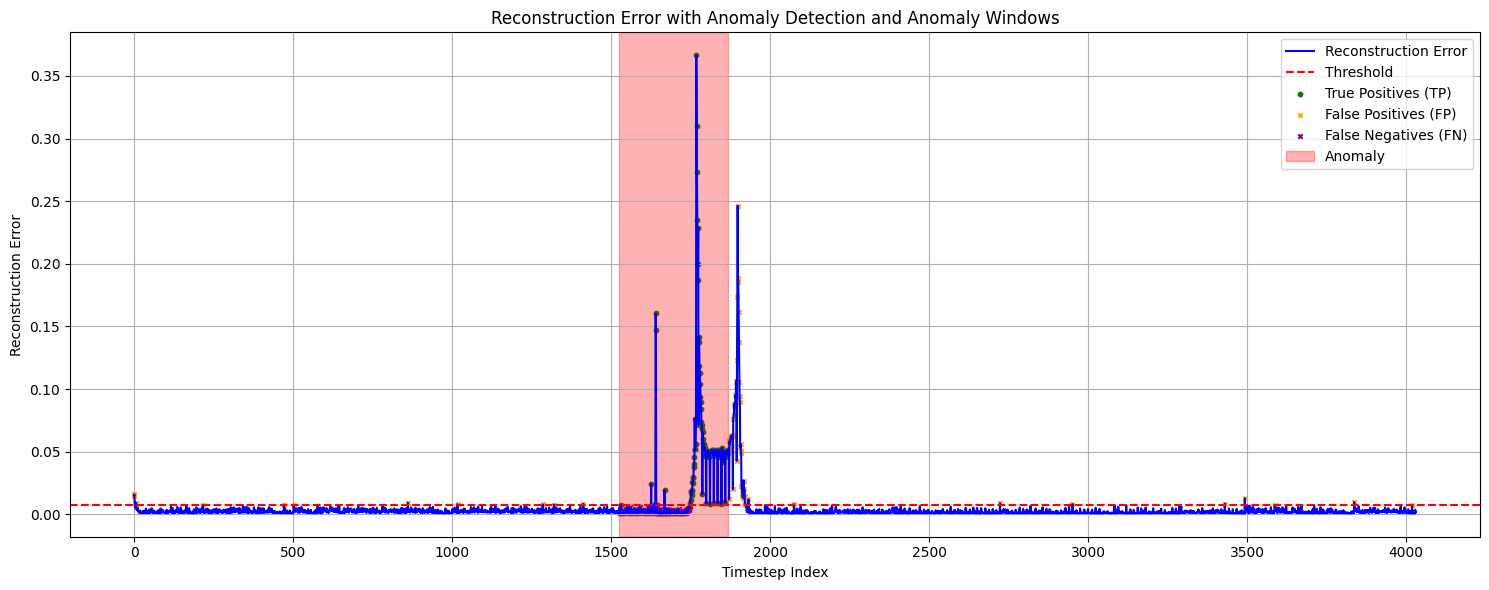

In [27]:
# 테스트 실행 (Static Threshold)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/StaticThreshold',
    threshold_method='static',
    threshold_percentile=95,
)

Using dynamic Reconstruction Error Threshold based on 20-window moving average and 1.0*std
[Classification Metrics]
Precision: 0.0983
Recall: 0.1691
F1-Score: 0.1243
ROC AUC: 0.6475
PR AUC: 0.3070
Cohen Kappa: 0.0188

Reconstruction error plot saved to results/H6_Attention/ec2_cpu_utilization_825cc2/DynamicThresholdwithMA/reconstruction_error_moving_avg_threshold.png


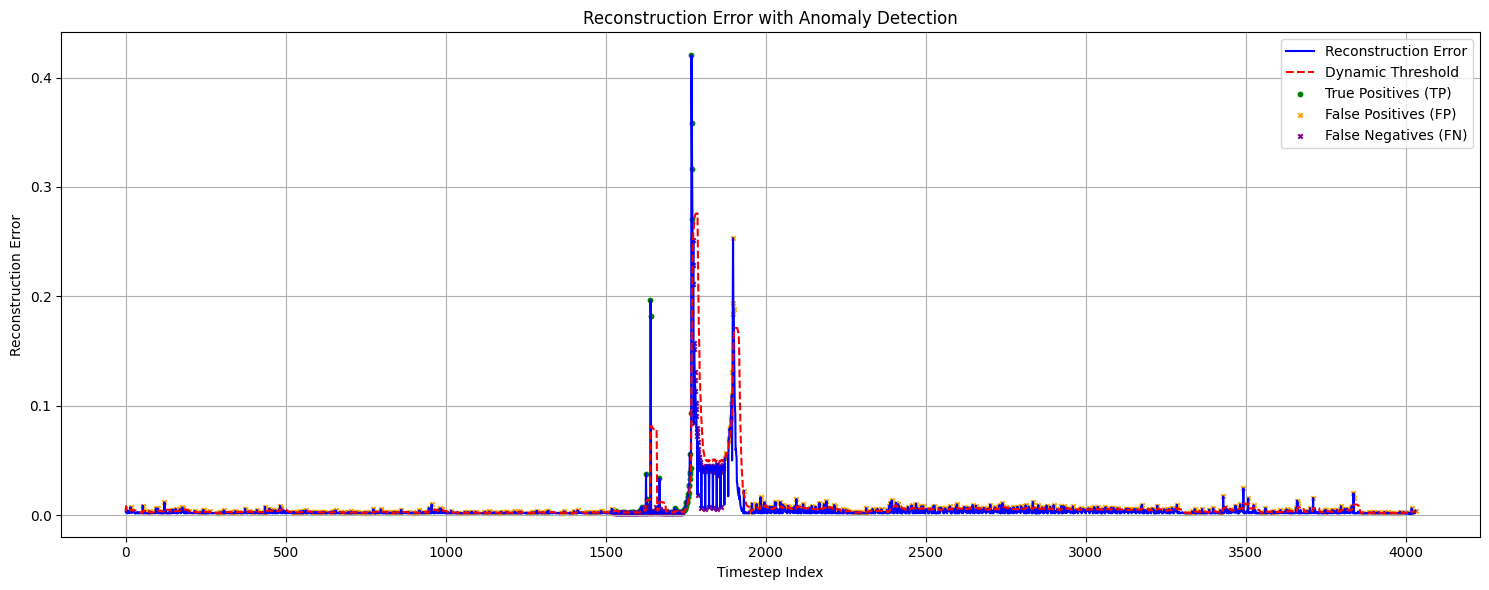

Actual vs Reconstructed Data plot saved to results/H6_Attention/ec2_cpu_utilization_825cc2/DynamicThresholdwithMA/actual_vs_reconstructed_data.png


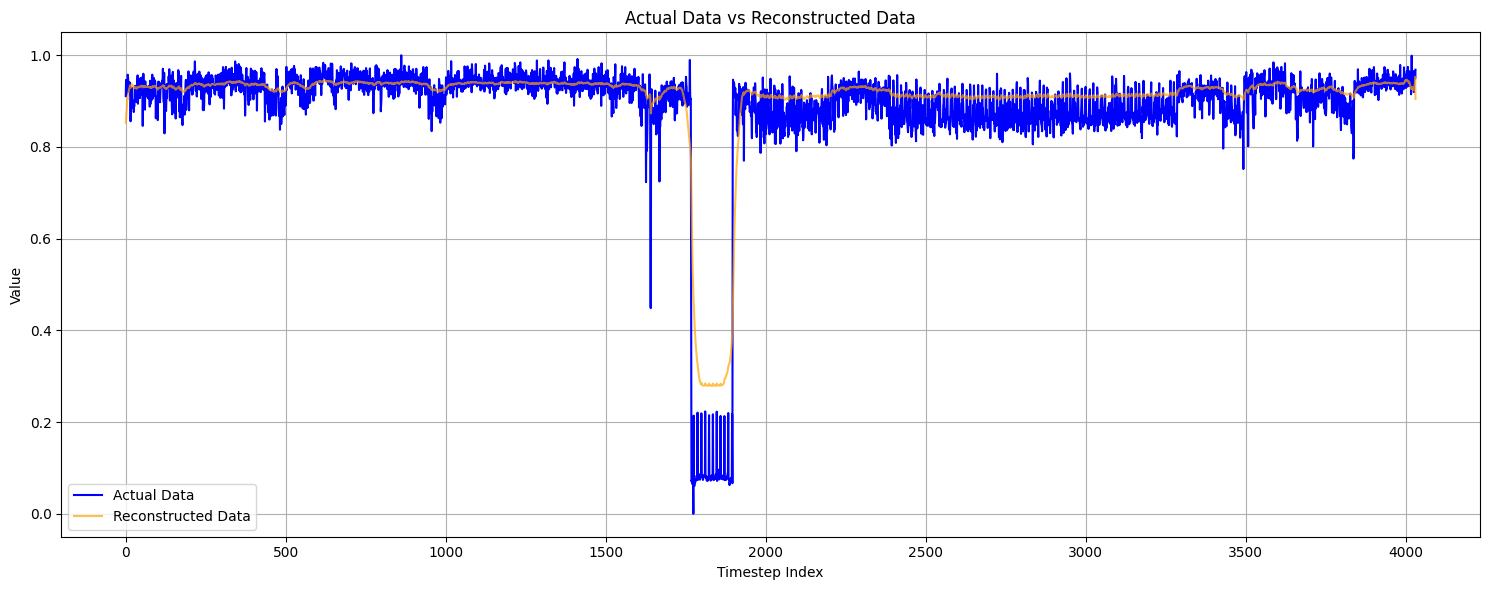

ROC curve plot saved to results/H6_Attention/ec2_cpu_utilization_825cc2/DynamicThresholdwithMA/roc_curve_all_data.png


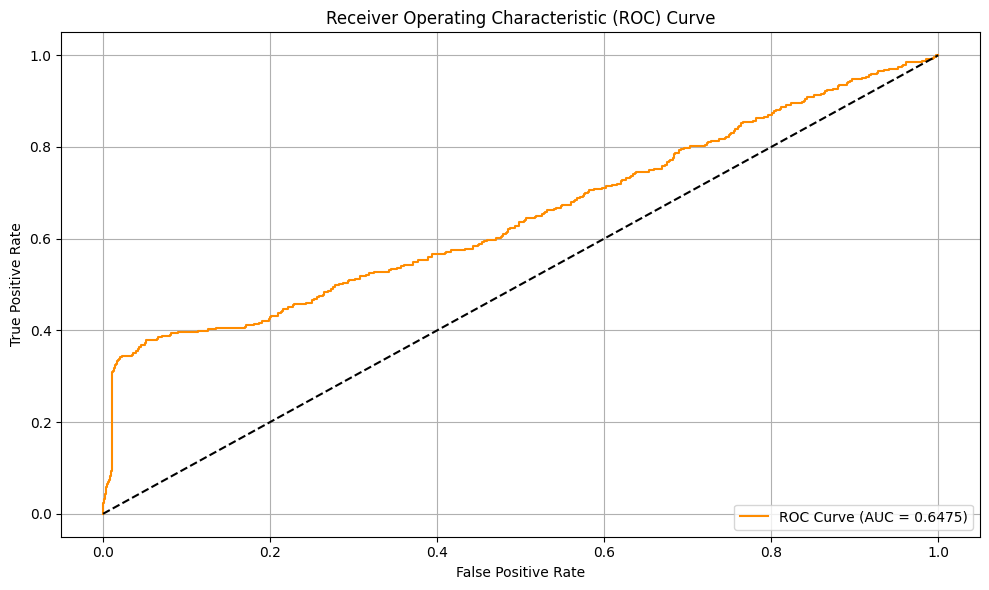

PR curve plot saved to results/H6_Attention/ec2_cpu_utilization_825cc2/DynamicThresholdwithMA/pr_curve_all_data.png


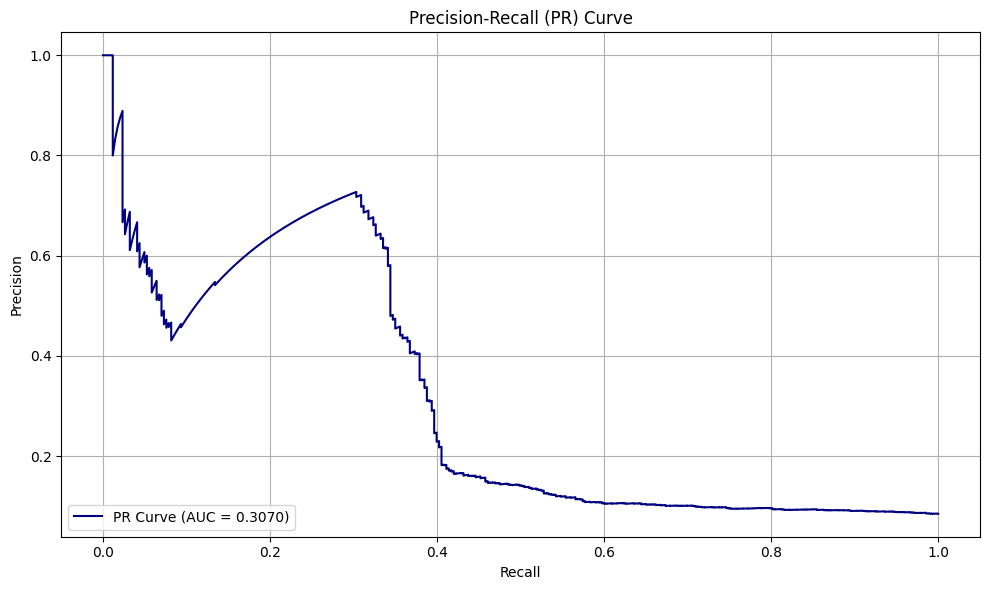

Confusion matrix plot saved to results/H6_Attention/ec2_cpu_utilization_825cc2/DynamicThresholdwithMA/confusion_matrix.png


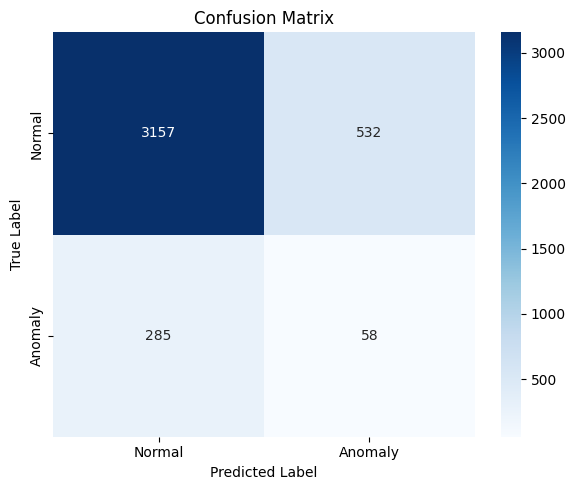

Reconstruction error with anomalies plot saved to results/H6_Attention/ec2_cpu_utilization_825cc2/DynamicThresholdwithMA/reconstruction_error_with_anomalies_moving_avg.png


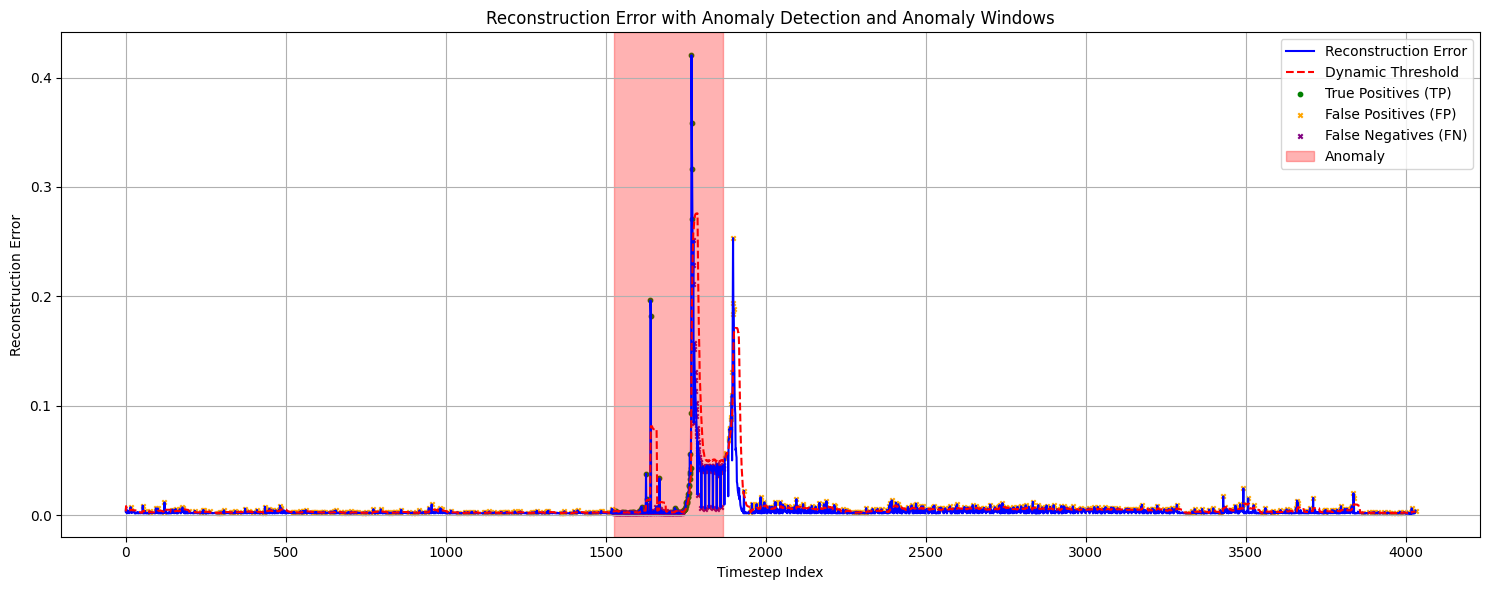

In [12]:
# 테스트 실행 (Dynamic Threshold, Moving Average)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithMA',
    threshold_method='moving_avg',
    k=1.0
)

Fitting GARCH(1,1) model on scaled reconstruction errors...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                31393.7
Distribution:                  Normal   AIC:                          -62781.5
Method:            Maximum Likelihood   BIC:                          -62762.6
                                        No. Observations:                 4032
Date:                Wed, Dec 04 2024   Df Residuals:                     4032
Time:                        03:03:17   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

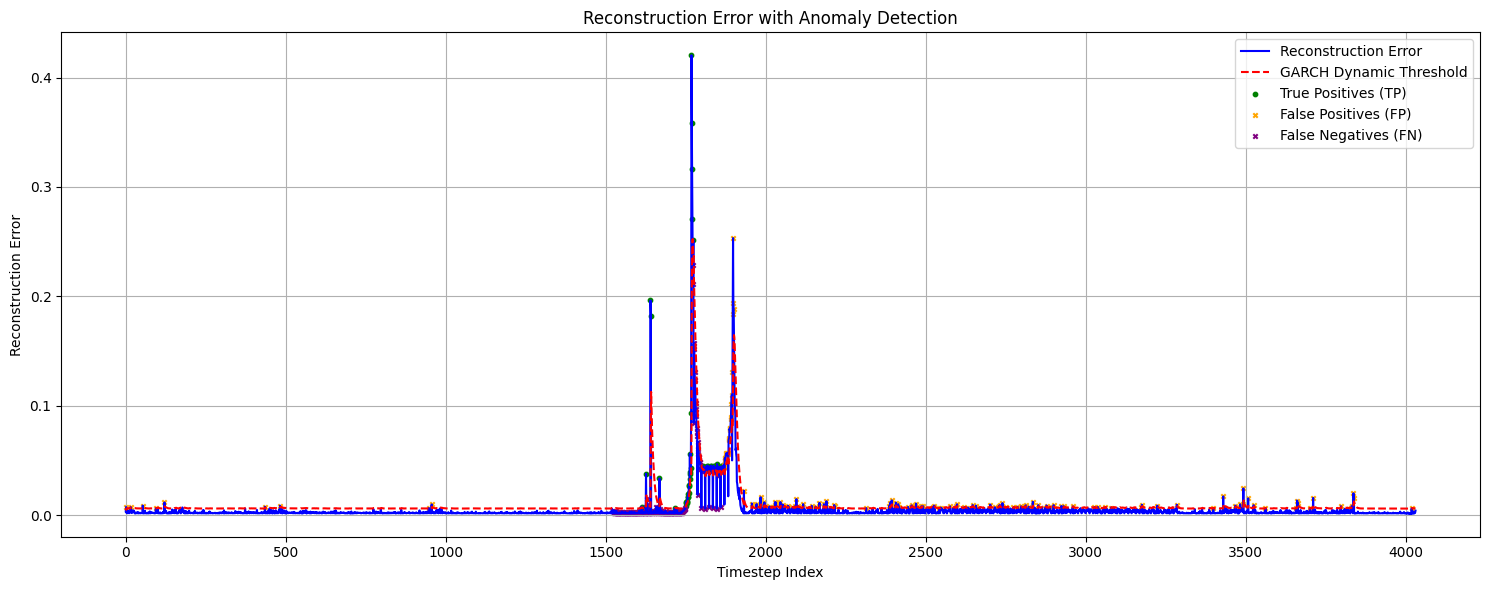

Actual vs Reconstructed Data plot saved to results/H6_Attention/ec2_cpu_utilization_825cc2/DynamicThresholdwithGARCH/actual_vs_reconstructed_data.png


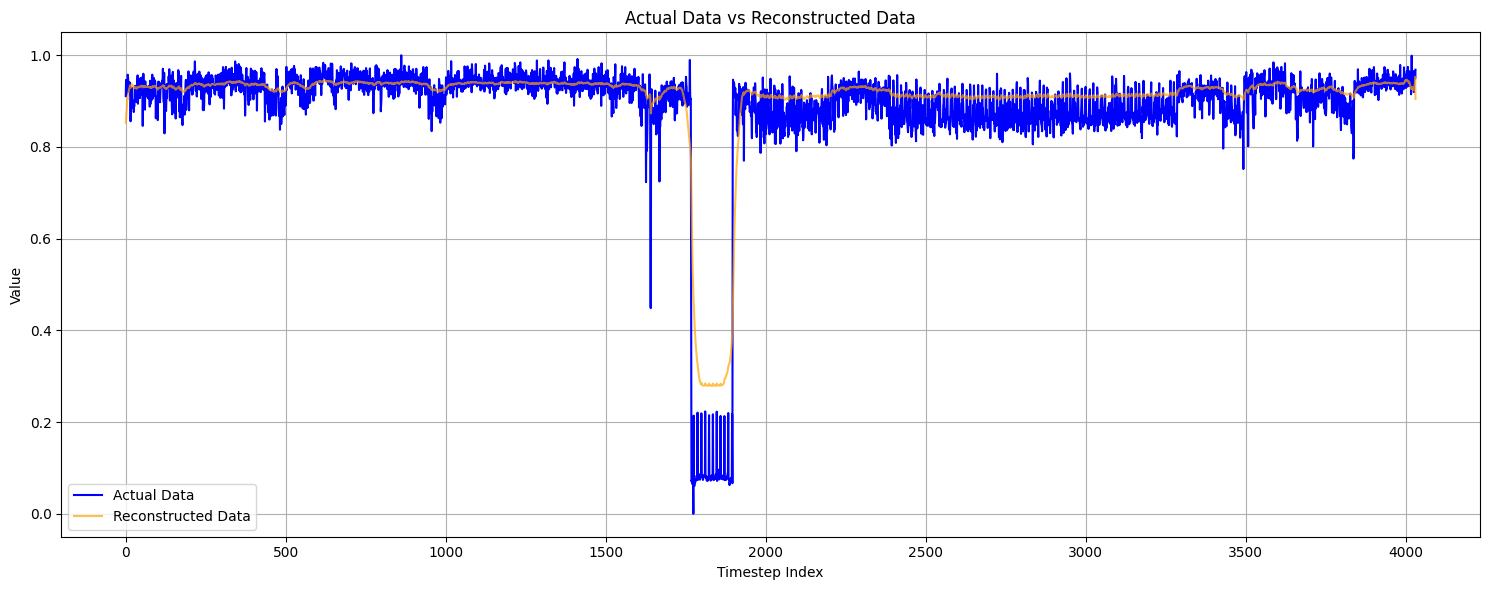

ROC curve plot saved to results/H6_Attention/ec2_cpu_utilization_825cc2/DynamicThresholdwithGARCH/roc_curve_all_data.png


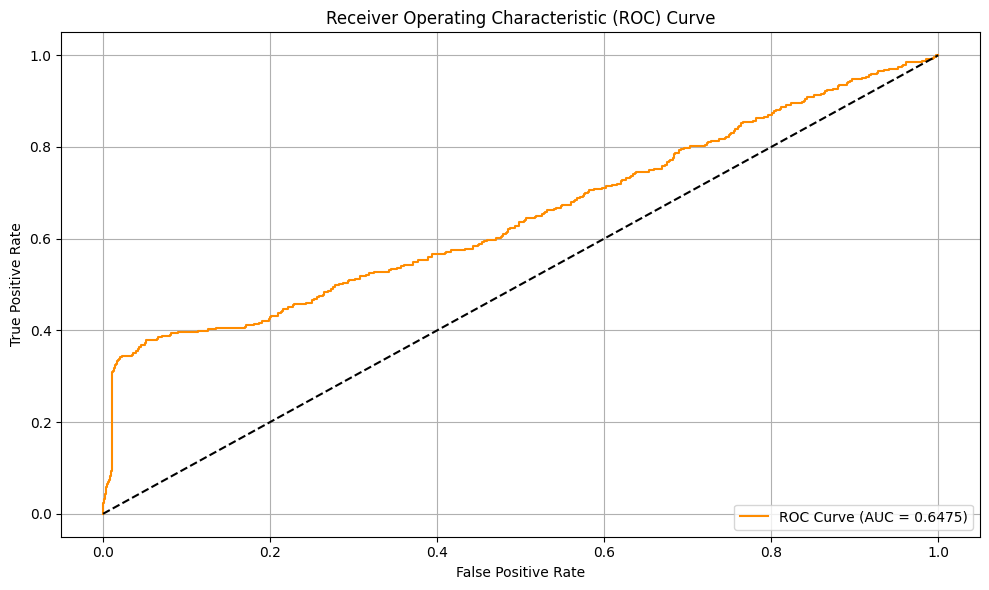

PR curve plot saved to results/H6_Attention/ec2_cpu_utilization_825cc2/DynamicThresholdwithGARCH/pr_curve_all_data.png


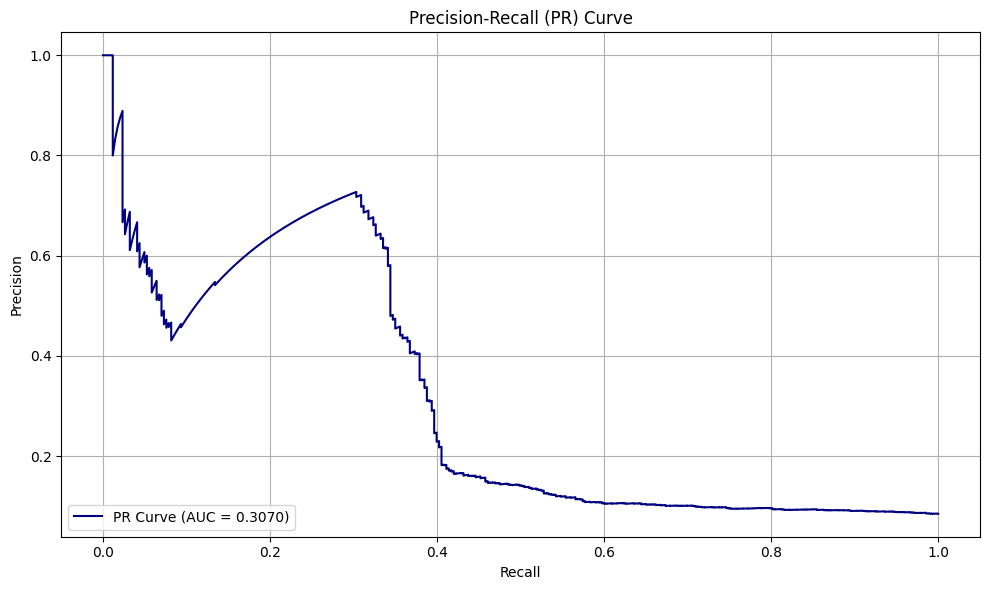

Confusion matrix plot saved to results/H6_Attention/ec2_cpu_utilization_825cc2/DynamicThresholdwithGARCH/confusion_matrix.png


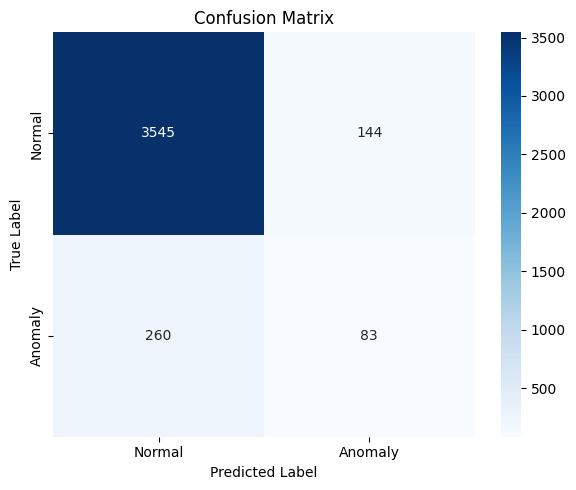

Reconstruction error with anomalies plot saved to results/H6_Attention/ec2_cpu_utilization_825cc2/DynamicThresholdwithGARCH/reconstruction_error_with_anomalies_garch.png


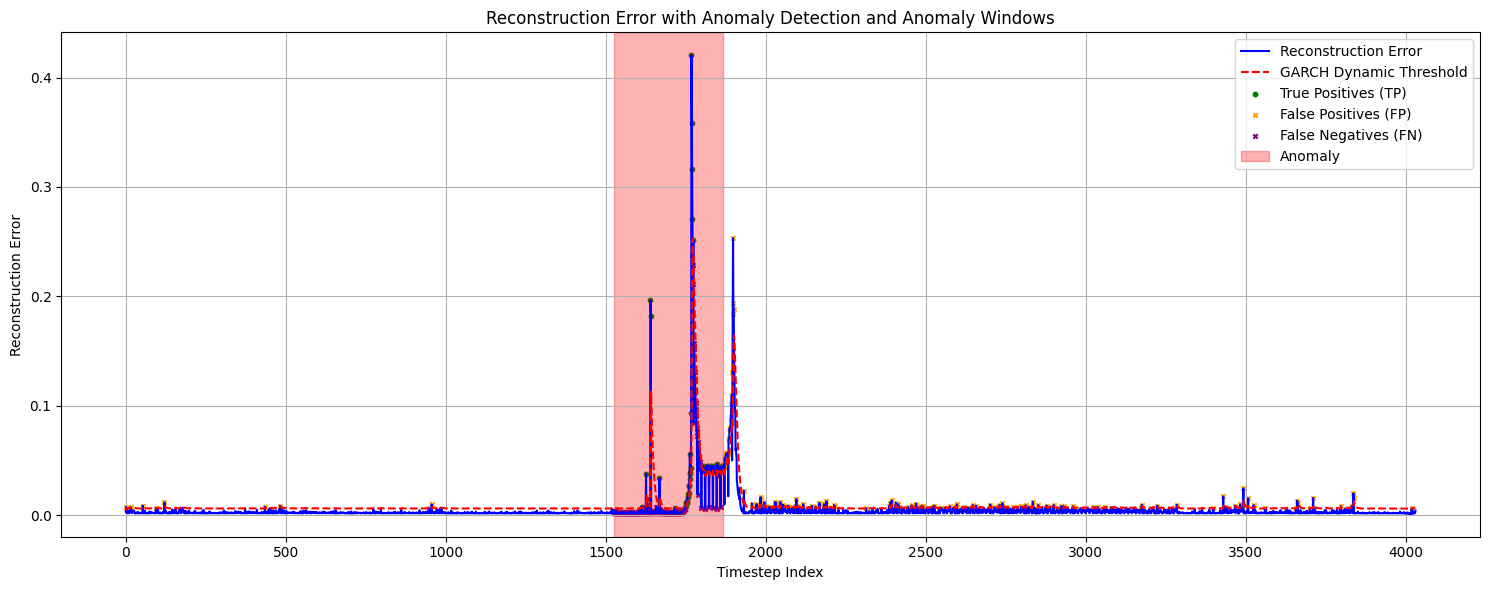

In [13]:
# 테스트 실행 (Dynamic Threshold, GARCH)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithGARCH',
    threshold_method='garch',
    k=1.0,
)

# art_daily_jumpsup

## Train

Hyperparameter & Hypothesis Number Setting Complete.
Model Initialization Complete.
Processing file: artificialWithAnomaly/art_daily_jumpsup.csv
Data Load Complete.
Loss function & Optimizer Complete.
[Args]
{'N': 10, 'input_size': 1, 'hidden_size': 8, 'output_size': 1, 'num_layers': 1, 'limit_skip_steps': 10, 'learning_rate': 0.001, 'l1_lambda': 1e-05, 'batch_size': 3997, 'window_size': 36, 'num_epochs': 1000, 'random_seed': 777}

[Model]
EASLAE(
  (autoencoders): ModuleList(
    (0-9): 10 x AutoEncoder(
      (encoder): Encoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
      )
      (decoder): Decoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
        (output_layer): Linear(in_features=16, out_features=1, bias=True)
        (attention): Linear(in_features=16, out_features=8, bias=True)
        (softmax): Softmax(dim=1)
      )
    )
  )
)

[Data

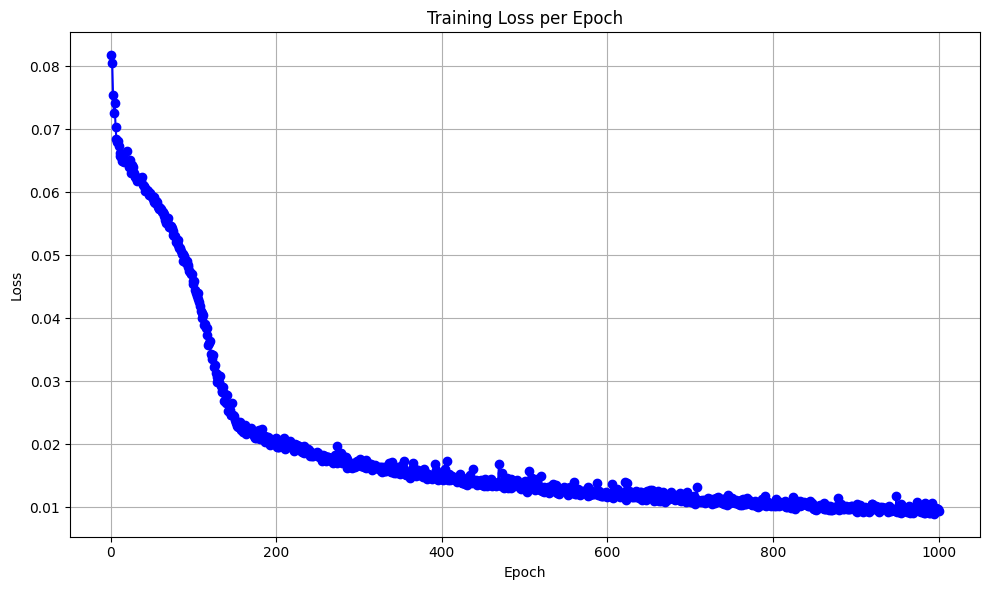

모델 가중치가 results/H6_Attention/art_daily_jumpsup/ensemble_autoencoder_weights.pth'에 저장되었습니다.


In [14]:
set_random_seed()

# 하이퍼파라미터 및 가설 넘버 설정
args = hyperparameter_setting(N=10, hidden_size=8, num_layers=1, num_epochs=1000,
                              window_size=36, l1_lambda=1e-5, limit_skip_steps=10, learning_rate=1e-3)
file_name = './NAB/data/artificialWithAnomaly/art_daily_jumpsup.csv'
h=os.path.join(h_name, os.path.basename(file_name).split('.')[0]) # 꼭 확인하기!
print("Hyperparameter & Hypothesis Number Setting Complete.")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)
model = EASLAE(
    N=args['N'],
    input_size=args['input_size'],
    hidden_size=args['hidden_size'],
    output_size=args['output_size'],
    num_layers=args['num_layers'],
    limit_skip_steps=args['limit_skip_steps'],
    seed=args['random_seed'],
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("Model Initialization Complete.")

# Prepare data and create Dataset
abnormal_data, abnormal_label = read_dataset(file_name)
abnormal_data, abnormal_label = abnormal_data[:], abnormal_label[:]  # Remove last data point to fit window and batch size

window_size = args['window_size']
stride = 1

# Create the train dataset
train_dataset = TimeSeriesDataset(abnormal_data, abnormal_label, window_size, stride=stride)
batch_size = args['batch_size'] = len(train_dataset) # args['batch_size']

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print("Data Load Complete.")

# 손실 함수 및 옵티마이저 설정 - 논문에선 Adadelta를 사용했으나, 20 epoch 동안 loss가 떨어지지 않아 Adam으로 대체
criterion = nn.MSELoss() # MSELoss, L1Loss, SmoothL1Loss
optimizer = optim.AdamW(model.parameters(), lr=args['learning_rate'], weight_decay=1e-5)
print("Loss function & Optimizer Complete.")

print("[Args]")
print(args)
print()

print("[Model]")
print(model)
print()

print("[Data]")
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of batches in train dataloader: {len(train_dataloader)}")
print()

print("[Criterion & Optimizer]")
print(criterion)
print(optimizer)
print()

# 학습 실행
print('현재 가설명:', h)
print()

train(
    model=model,
    dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    l1_lambda=args['l1_lambda'],
    num_epochs=args['num_epochs'],
    h=h
)

# 모델 가중치 저장
torch.save(model.state_dict(), f'results/{h}/ensemble_autoencoder_weights.pth')
print(f"모델 가중치가 results/{h}/ensemble_autoencoder_weights.pth'에 저장되었습니다.")

## Test

In [15]:
model.load_state_dict(torch.load(f'results/{h}/ensemble_autoencoder_weights.pth', weights_only=True))
print("모델 가중치가 로드되었습니다.")

# 테스트 파일 불러오기
test_file_name = file_name # Train한 file과 동일한 file로 진행
test_abnormal_data, test_abnormal_label = read_dataset(test_file_name)
test_abnormal_data, test_abnormal_label = test_abnormal_data[:], test_abnormal_label[:]

# 모든 데이터를 테스트에 사용
test_dataset = TimeSeriesDataset(test_abnormal_data, test_abnormal_label, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

total_length = len(test_abnormal_data)

all_errors, reconstructed_data, binary_labels = compute_reconstruction_errors(model, test_dataloader, device, total_length, test_abnormal_label)

모델 가중치가 로드되었습니다.
Processing file: artificialWithAnomaly/art_daily_jumpsup.csv
Testing Complete.


Using static Reconstruction Error Threshold (95th percentile): 0.011747
[Classification Metrics]
Precision: 0.5050
Recall: 0.2531
F1-Score: 0.3372
ROC AUC: 0.6175
PR AUC: 0.2780
Cohen Kappa: 0.2898

Reconstruction error plot saved to results/H6_Attention/art_daily_jumpsup/StaticThreshold/reconstruction_error_static_threshold.png


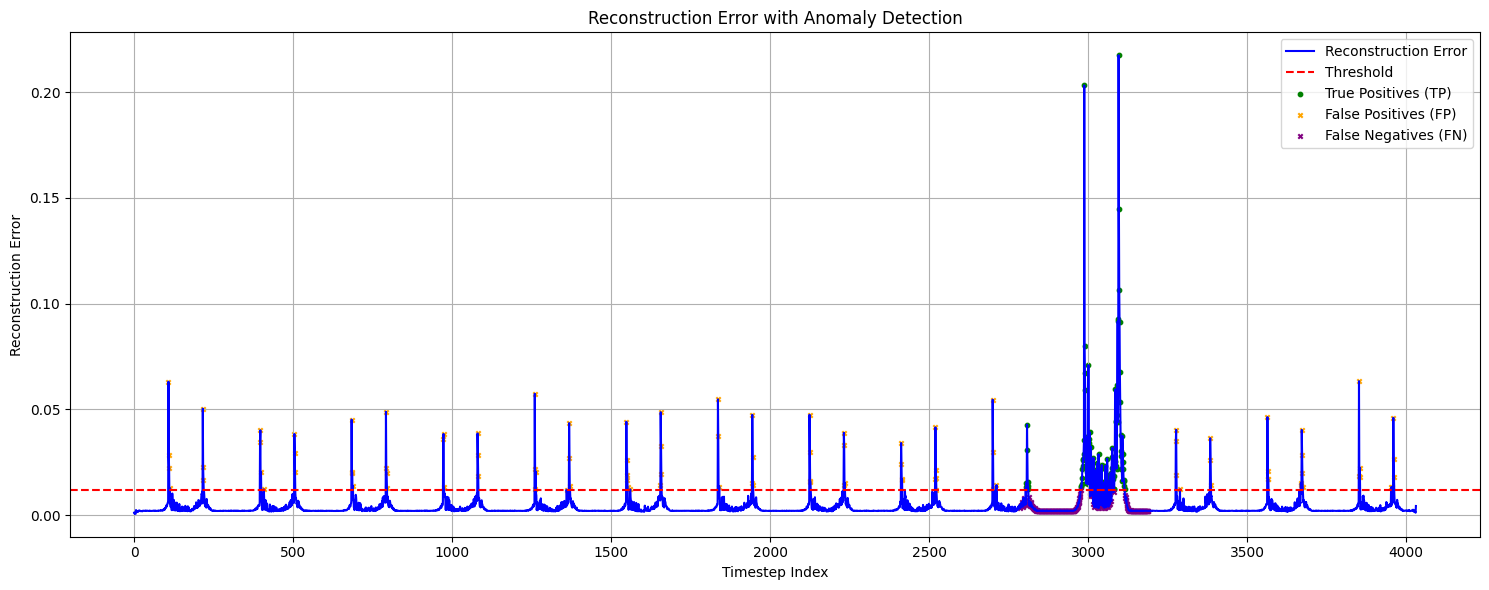

Actual vs Reconstructed Data plot saved to results/H6_Attention/art_daily_jumpsup/StaticThreshold/actual_vs_reconstructed_data.png


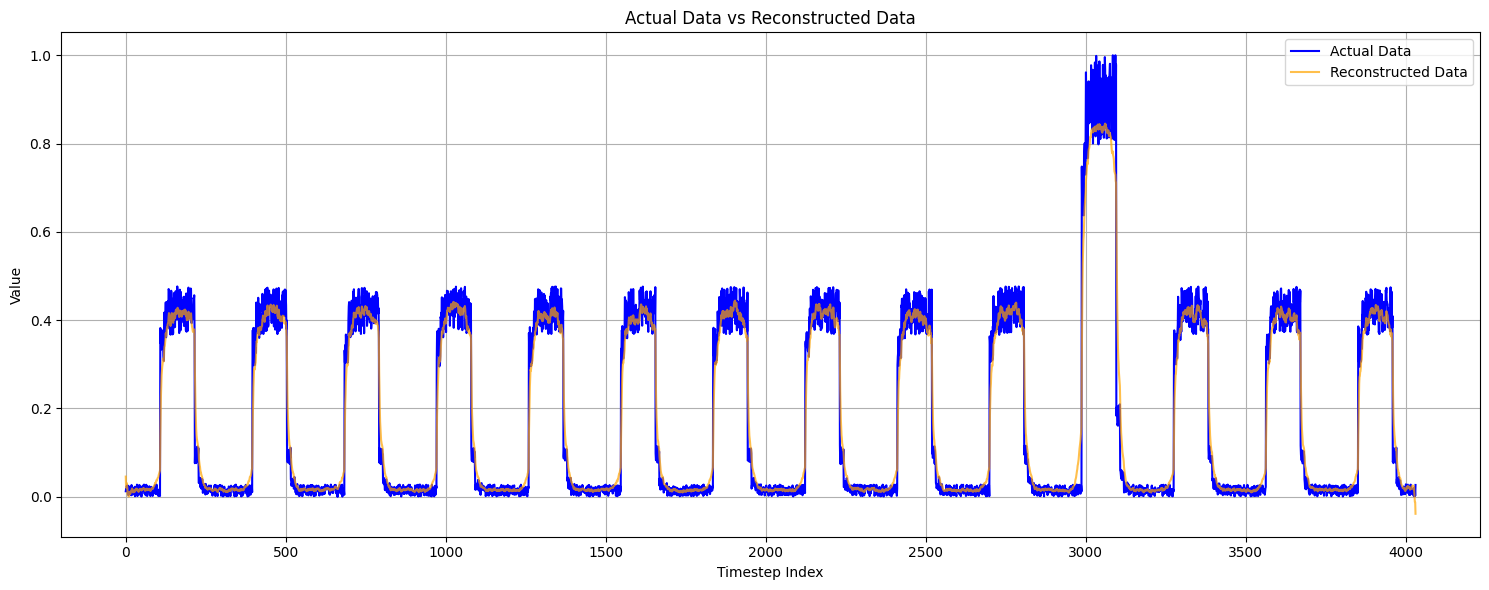

ROC curve plot saved to results/H6_Attention/art_daily_jumpsup/StaticThreshold/roc_curve_all_data.png


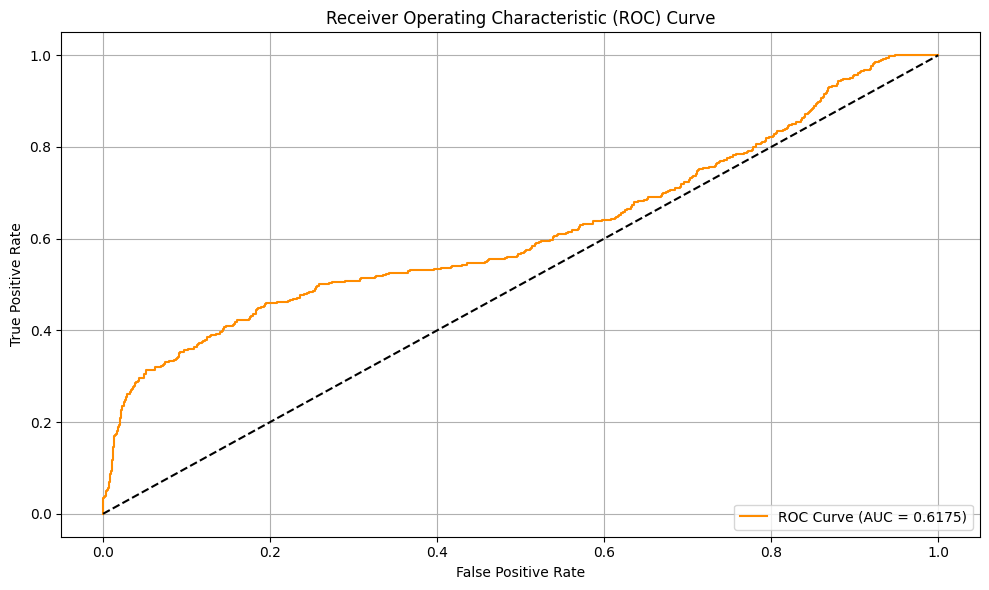

PR curve plot saved to results/H6_Attention/art_daily_jumpsup/StaticThreshold/pr_curve_all_data.png


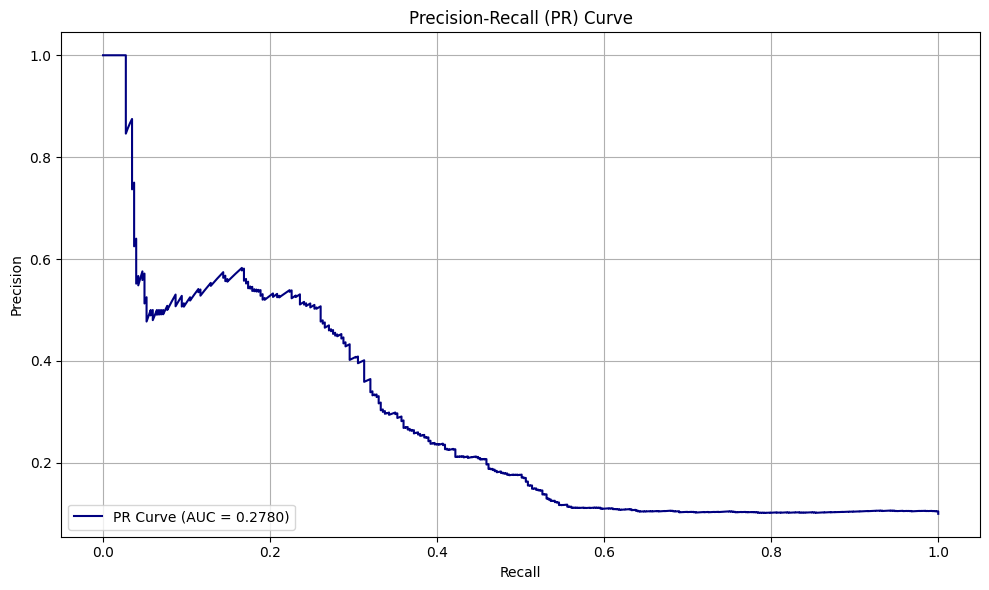

Confusion matrix plot saved to results/H6_Attention/art_daily_jumpsup/StaticThreshold/confusion_matrix.png


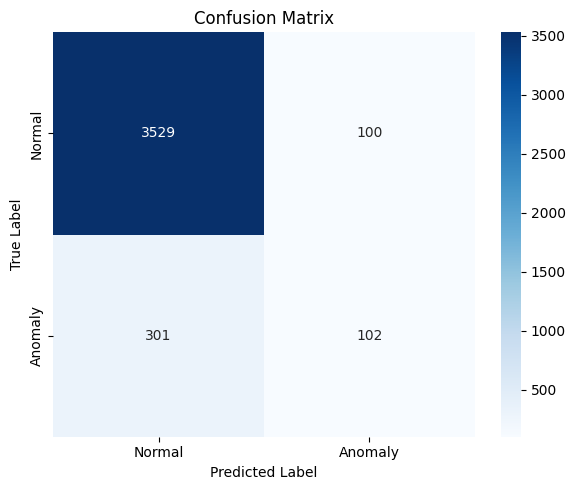

Reconstruction error with anomalies plot saved to results/H6_Attention/art_daily_jumpsup/StaticThreshold/reconstruction_error_with_anomalies_static.png


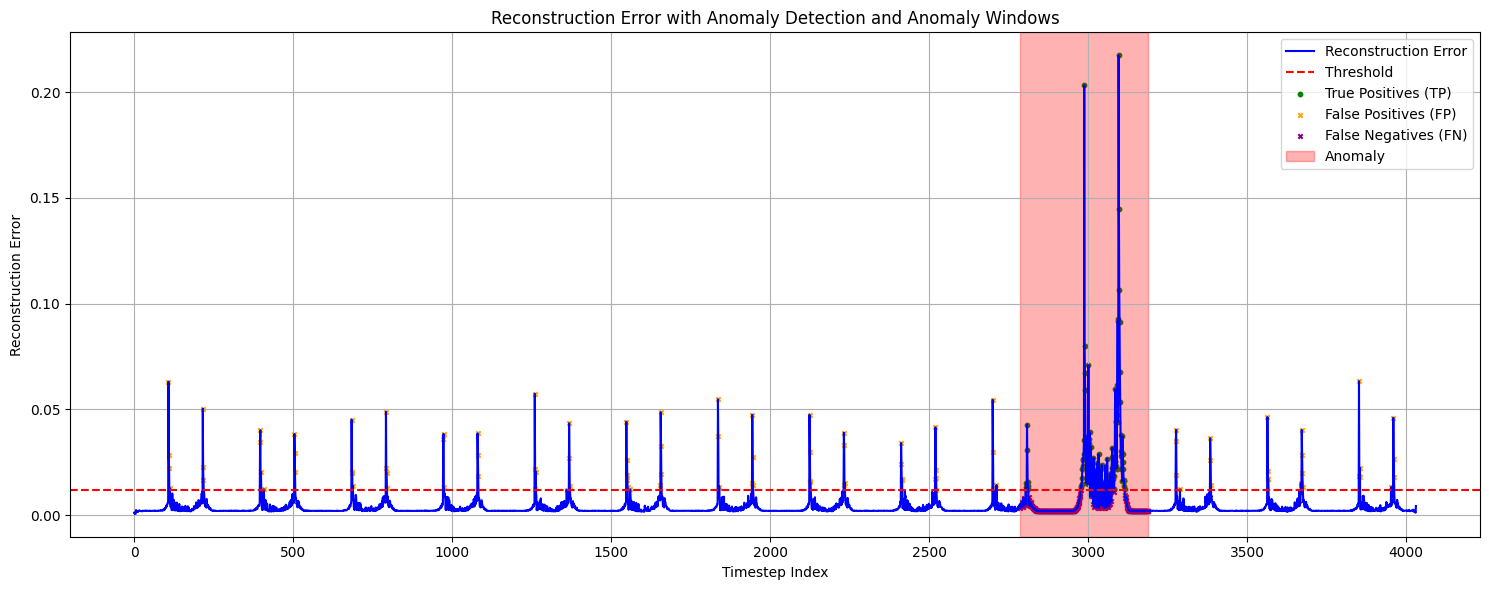

In [16]:
# 테스트 실행 (Static Threshold)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/StaticThreshold',
    threshold_method='static',
    threshold_percentile=95,
)

Using dynamic Reconstruction Error Threshold based on 20-window moving average and 1.0*std
[Classification Metrics]
Precision: 0.1089
Recall: 0.2407
F1-Score: 0.1499
ROC AUC: 0.6175
PR AUC: 0.2780
Cohen Kappa: 0.0142

Reconstruction error plot saved to results/H6_Attention/art_daily_jumpsup/DynamicThresholdwithMA/reconstruction_error_moving_avg_threshold.png


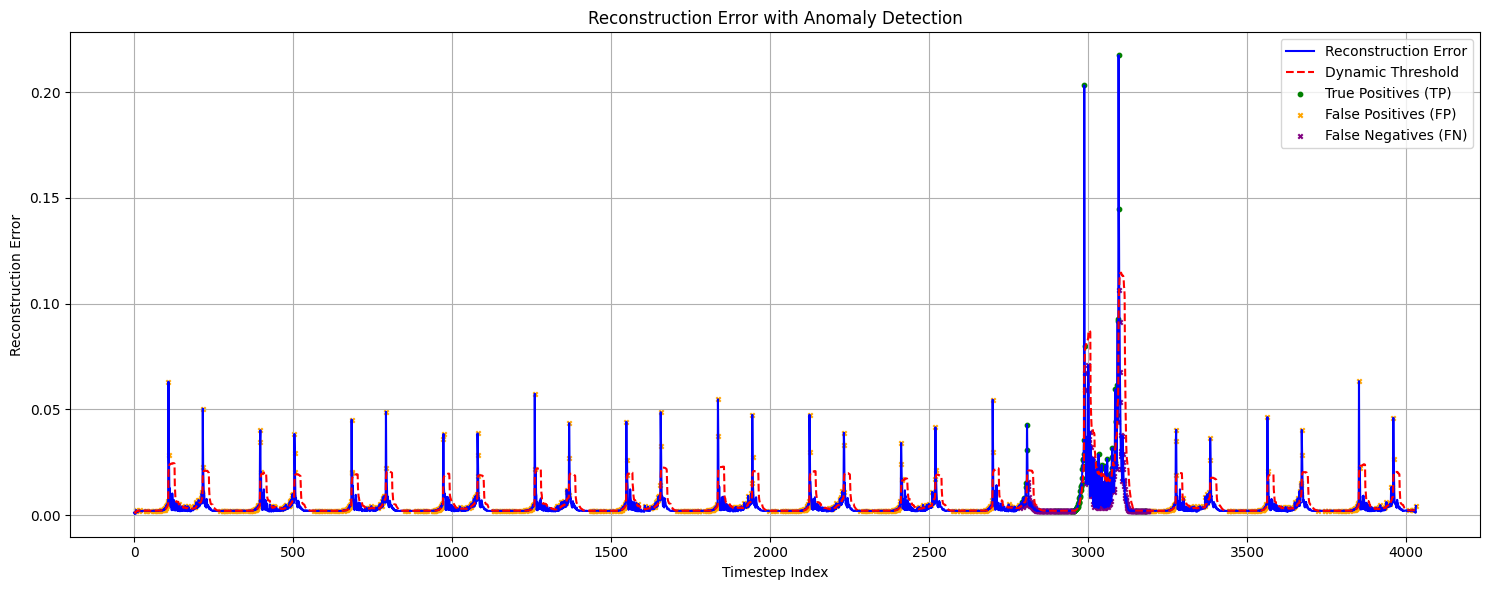

Actual vs Reconstructed Data plot saved to results/H6_Attention/art_daily_jumpsup/DynamicThresholdwithMA/actual_vs_reconstructed_data.png


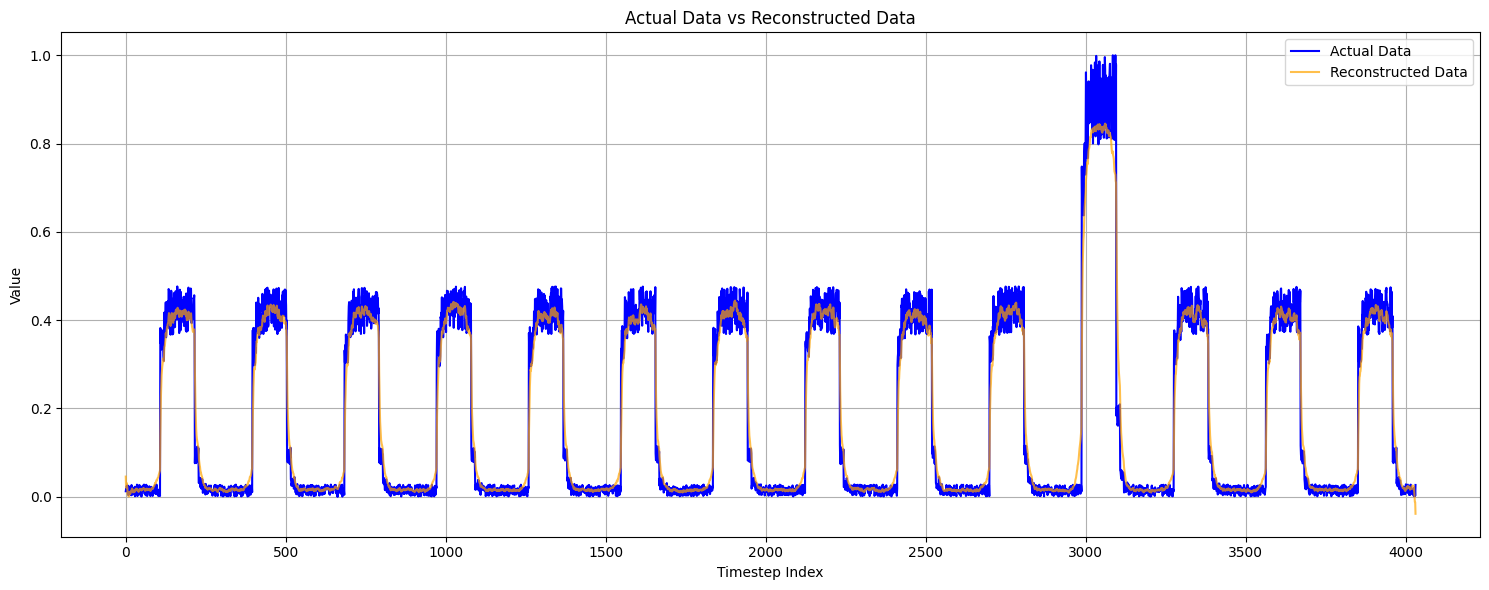

ROC curve plot saved to results/H6_Attention/art_daily_jumpsup/DynamicThresholdwithMA/roc_curve_all_data.png


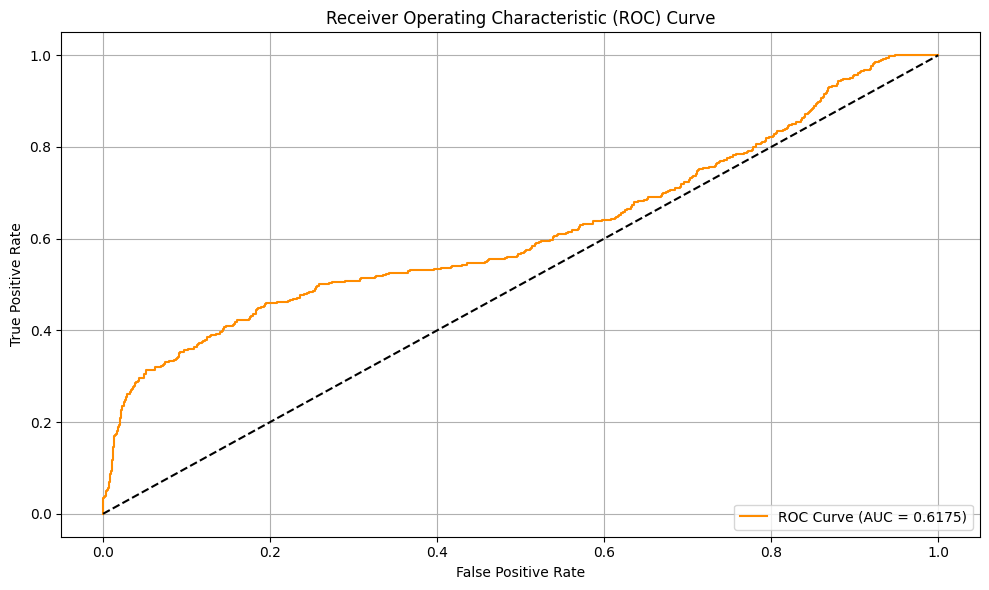

PR curve plot saved to results/H6_Attention/art_daily_jumpsup/DynamicThresholdwithMA/pr_curve_all_data.png


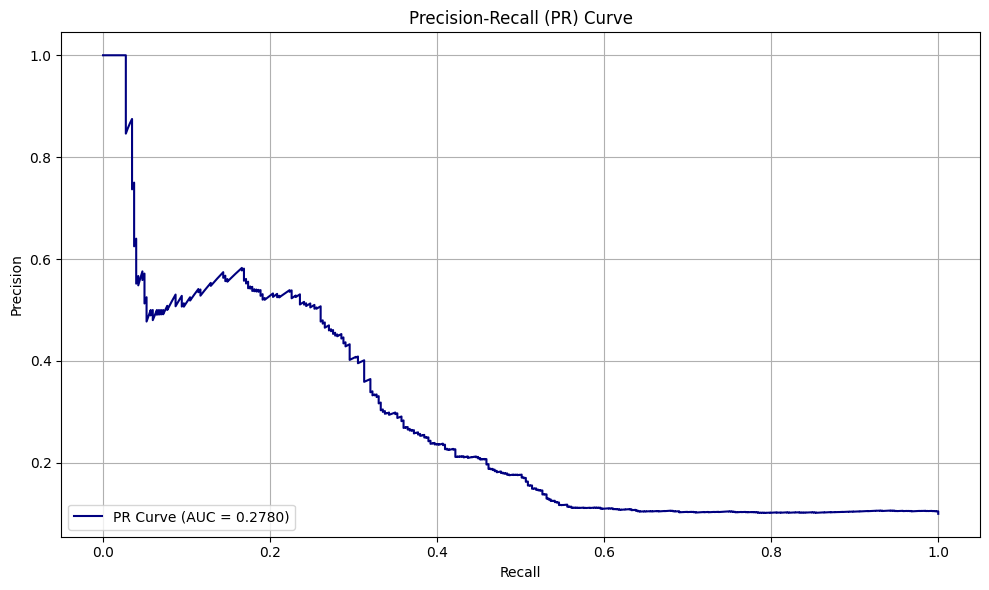

Confusion matrix plot saved to results/H6_Attention/art_daily_jumpsup/DynamicThresholdwithMA/confusion_matrix.png


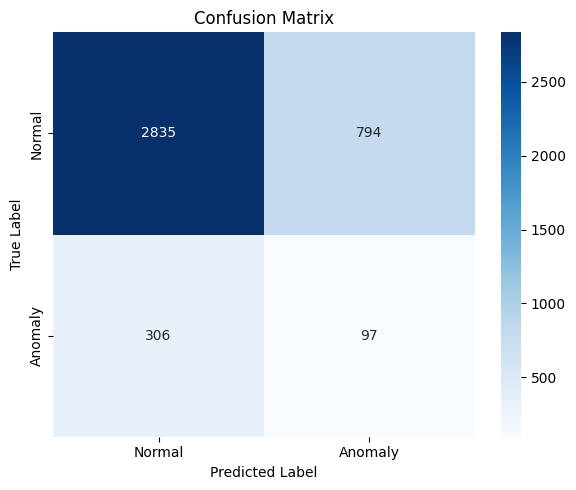

Reconstruction error with anomalies plot saved to results/H6_Attention/art_daily_jumpsup/DynamicThresholdwithMA/reconstruction_error_with_anomalies_moving_avg.png


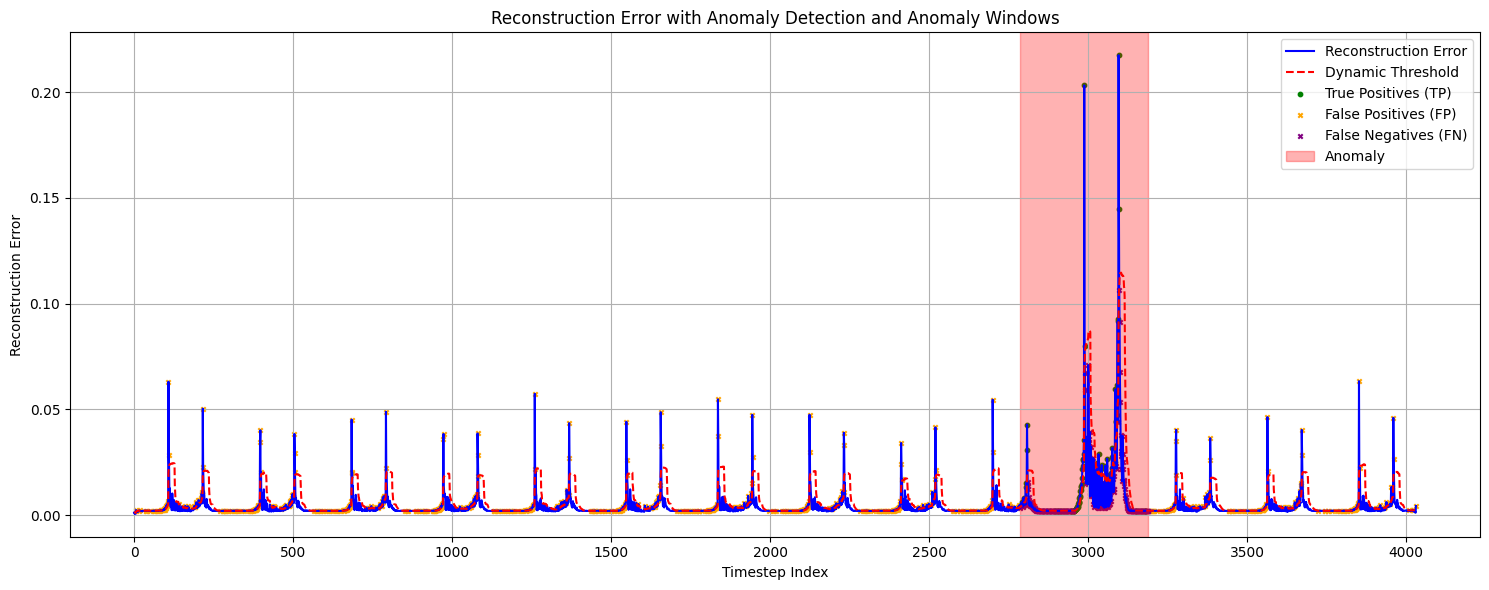

In [17]:
# 테스트 실행 (Dynamic Threshold, Moving Average)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithMA',
    threshold_method='moving_avg',
    k=1.0
)

Fitting GARCH(1,1) model on scaled reconstruction errors...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                35388.2
Distribution:                  Normal   AIC:                          -70770.4
Method:            Maximum Likelihood   BIC:                          -70751.5
                                        No. Observations:                 4032
Date:                Wed, Dec 04 2024   Df Residuals:                     4032
Time:                        03:22:26   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

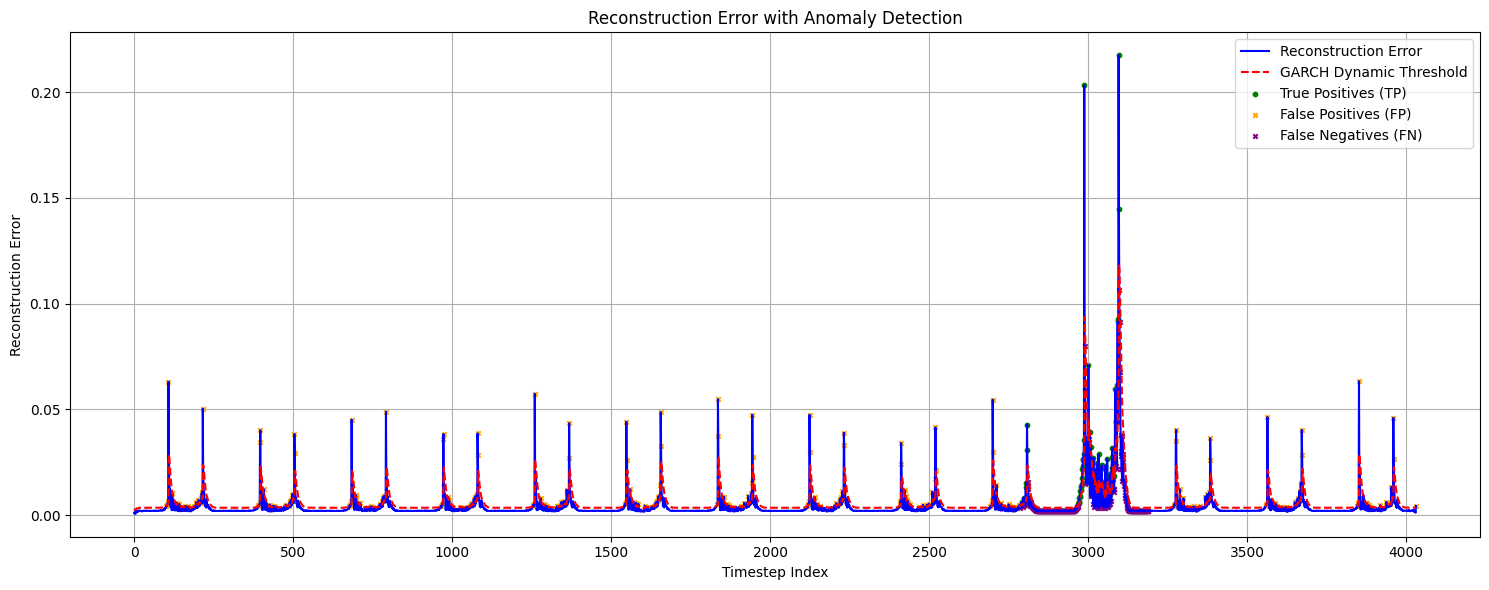

Actual vs Reconstructed Data plot saved to results/H6_Attention/art_daily_jumpsup/DynamicThresholdwithGARCH/actual_vs_reconstructed_data.png


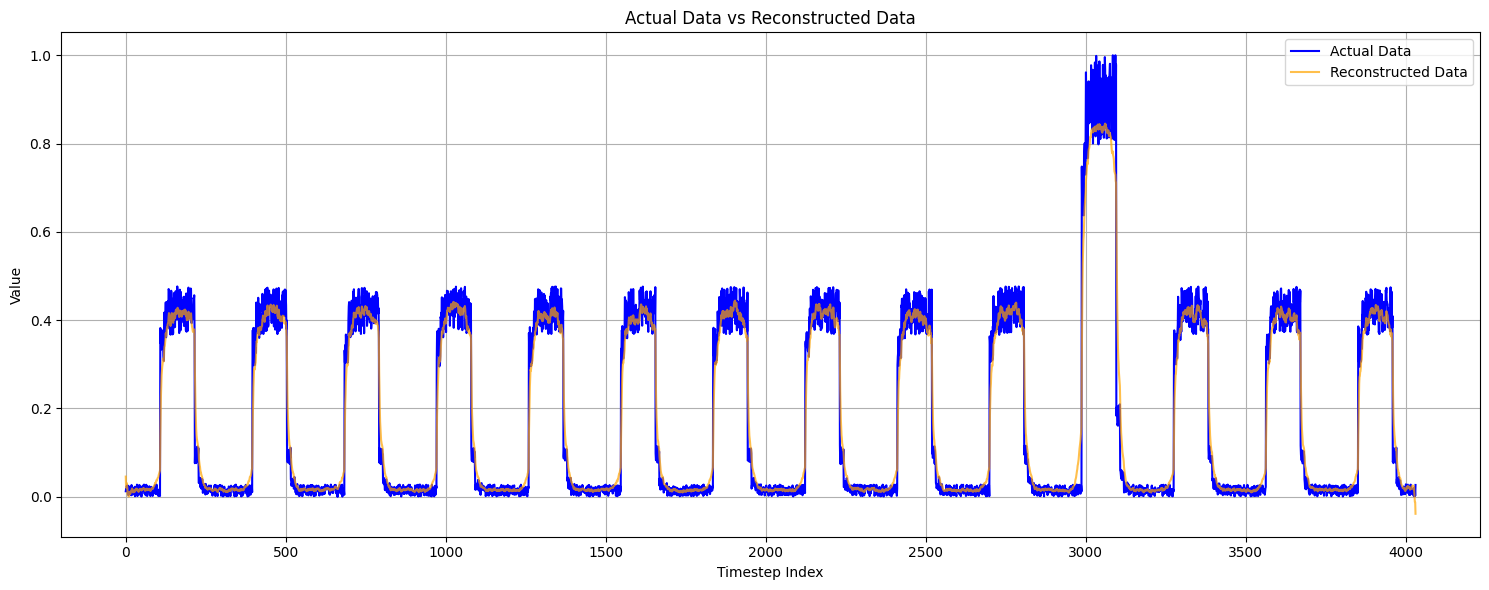

ROC curve plot saved to results/H6_Attention/art_daily_jumpsup/DynamicThresholdwithGARCH/roc_curve_all_data.png


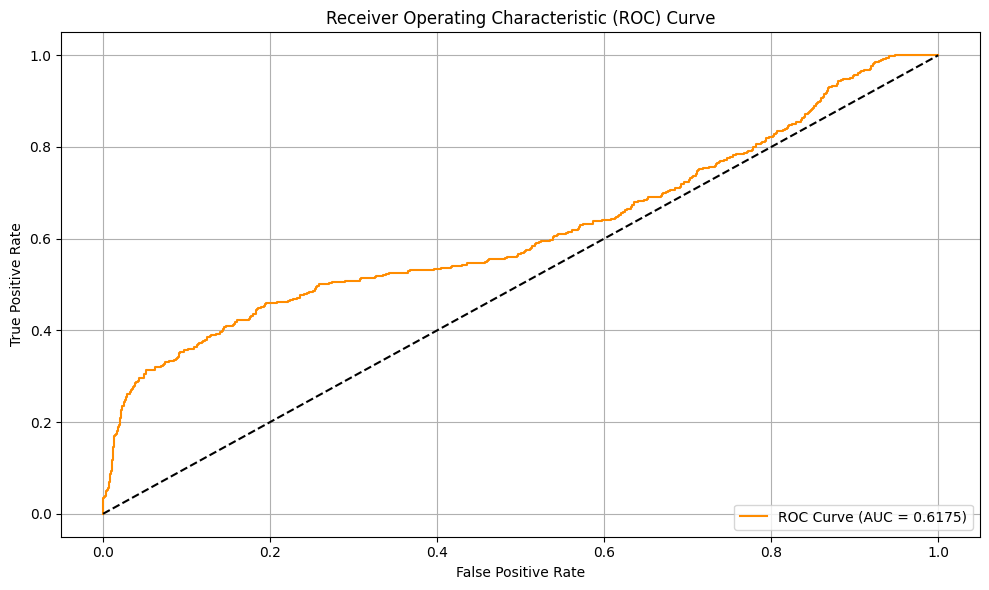

PR curve plot saved to results/H6_Attention/art_daily_jumpsup/DynamicThresholdwithGARCH/pr_curve_all_data.png


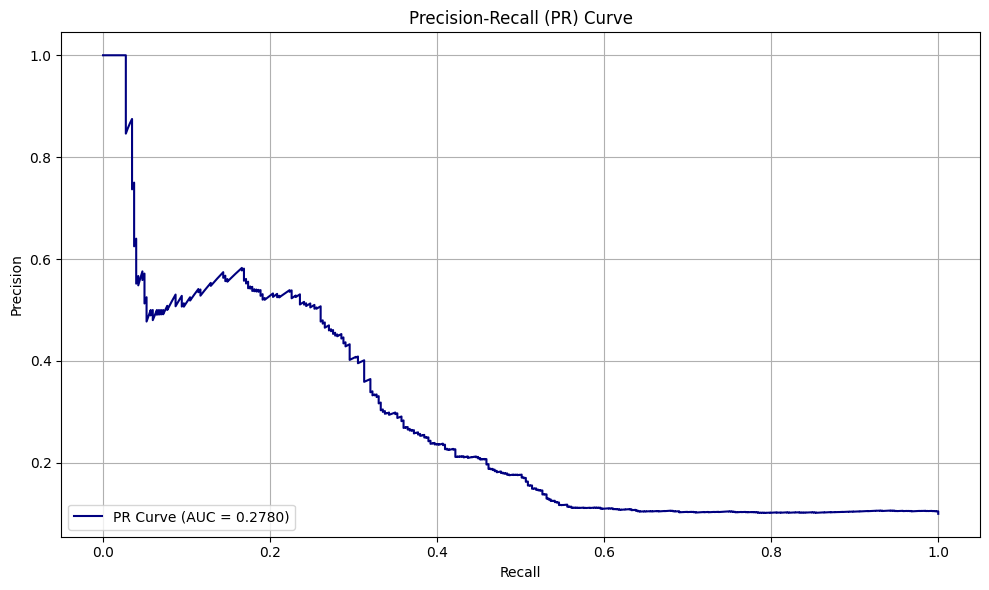

Confusion matrix plot saved to results/H6_Attention/art_daily_jumpsup/DynamicThresholdwithGARCH/confusion_matrix.png


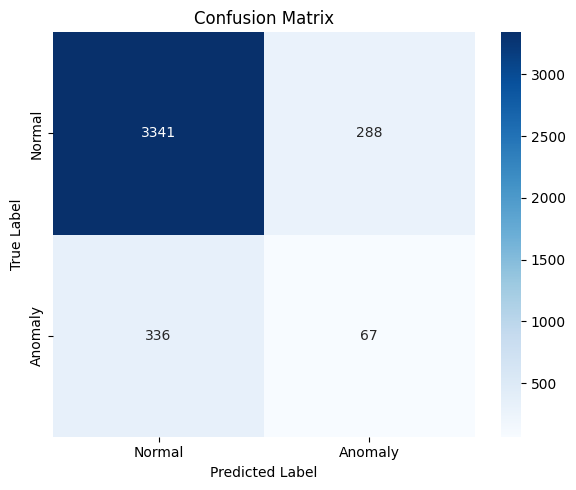

Reconstruction error with anomalies plot saved to results/H6_Attention/art_daily_jumpsup/DynamicThresholdwithGARCH/reconstruction_error_with_anomalies_garch.png


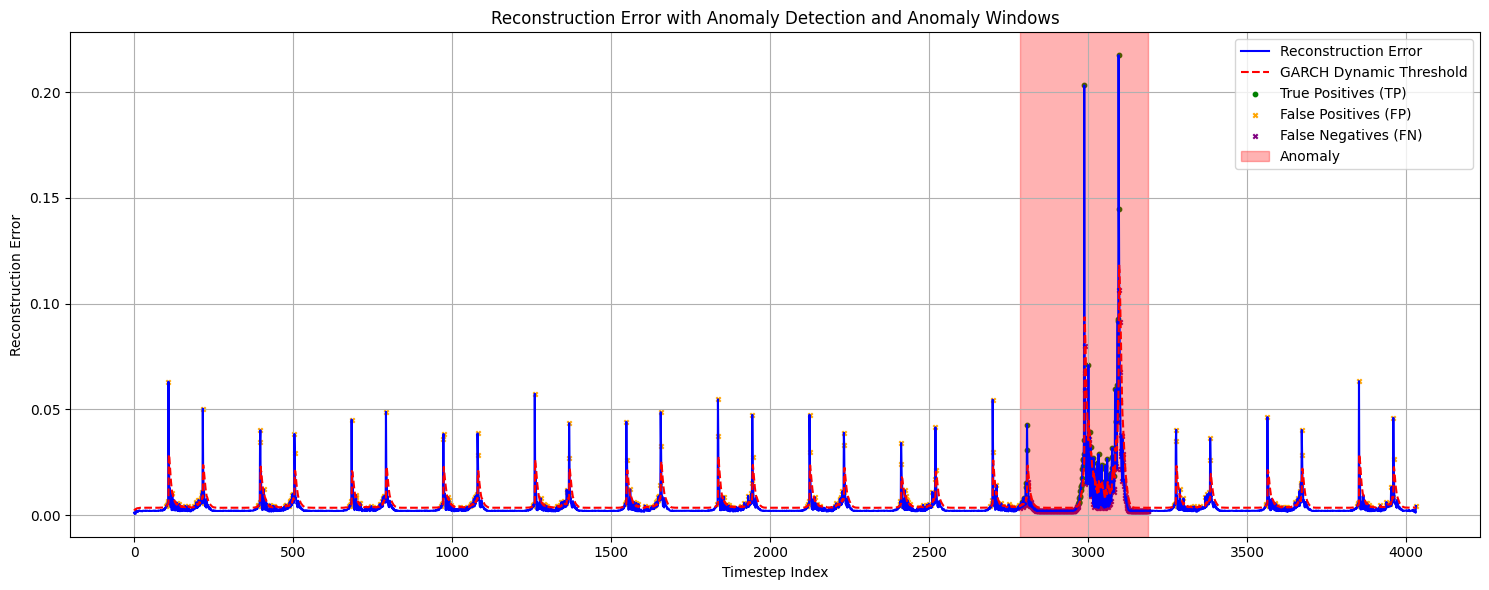

In [18]:
# 테스트 실행 (Dynamic Threshold, GARCH)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithGARCH',
    threshold_method='garch',
    k=1.0,
)

In [19]:
import os
import shutil
from google.colab import drive

# 원본 경로
source_path = '/content/results'

# 목적지 경로
destination_path = '/content/drive/MyDrive/results'

# 목적지 경로가 없으면 생성
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

# '/content' 경로에 있는 모든 파일과 폴더를 이동
for filename in os.listdir(source_path):
    file_path = os.path.join(source_path, filename)
    if os.path.isfile(file_path) or os.path.isdir(file_path):
        shutil.move(file_path, destination_path)